# WFIP2/MMC Case: 2016-11-21
* "CBS-": cross-barrier synoptic
* mountain waves
* topographic wakes

power ramp event "VOL"

Started from Analysis_2016-11-21

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import pytz

In [3]:
import pickle

In [4]:
from datatools import wfip2, remote_sensing

## Setup

In [5]:
plt.style.use('seaborn-darkgrid')

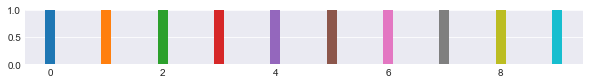

In [6]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#colors.pop(5)

fig,ax = plt.subplots(figsize=(10,1))
for i,color in enumerate(colors):
    ax.axvline(i,color=color,lw=10)

In [7]:
zref = 80.0
R2_min = 0.5

In [8]:
starttime = pd.datetime(2016,11,21,0,0,0)
endtime = pd.datetime(2016,11,22,12,0,0)
#resample_freq = '10S'
#t = pd.date_range(start=starttime,end=endtime,freq=resample_freq)

In [9]:
timezone_str = 'US/Pacific'
utc_tz = pytz.timezone('UTC')
local_tz = pytz.timezone(timezone_str)

In [10]:
# local weather

# station 726988 (air force datsav3 number), a.k.a. The Dalles Municipal Airport
# should be same data as:
# https://www.wunderground.com/history/airport/KDLS/2016/11/21/DailyHistory.html?req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=
isddata = '/Users/equon/WFIP2/weather/726988-24219-2016'

In [11]:
# Surface radiation measureents
srad_dpath = '/Users/equon/WFIP2/PS07/201611'
srad_prefix = 'met.z07.b0.2016112'
srad_ext = 'txt'

In [12]:
# SODAR (TI estimate)
ps01_dpath = '/Users/equon/WFIP2/PS01/sodar.z12.b0/201611'
ps01_prefix = ''
ps01_ext = 'txt'

In [13]:
# Wind Profiler 915Hz, RASS
radar_dpath = '/Users/equon/WFIP2/Wasco/radar.z04.b0/201611'
radar_prefix = 'radar.z04.b0.2016112'
radar_wind_ext = '.winds'
radar_rass_ext = '.temp.txt'

In [14]:
# Operational power curves
# extracted in turbine_operational_power_curves.ipynb
power_curves = '/Users/equon/WFIP2/PGE/power_curves.csv'

## PS-12
Surface Meteorological Station • ANL 80m, Sonic, Physics site-12 • Reviewed Data <br>
wfip2/met.z28.b0: south facing <br>
wfip2/met.z29.b0: west facing

In [15]:
# def load_ANL_met_data(fname,starttime=pd.datetime(1900,1,1),endtime=pd.datetime.now(),datetimename='collection_time'):
#     df = pd.read_csv(fname,parse_dates=[datetimename])
#     daterange = (df[datetimename] >= starttime) & (df[datetimename] <= endtime)
#     df = df.loc[daterange]
#     df['UTC'] = df[datetimename].apply(lambda x: x.tz_localize(utc_tz))
#     df['local_time'] = df['UTC'].apply(lambda x: x.astimezone(local_tz) )
#     df['u'] = df['Y'] / 100.0 # positive toward east [m/s]
#     df['v'] = df['X'] / 100.0 # positive toward north [m/s]
#     df['w'] = df['Z'] / 100.0 # positive up [m/s]
#     df['temperature'] = df['T'] / 100.0 # sonic virtual temperature [deg C]
#     df['horizontal_wind_speed'] = np.sqrt(df['u']**2 + df['v']**2)
#     df['wind_speed'] = np.sqrt(df['u']**2 + df['v']**2 + df['w']**2)
#     df['wind_direction'] = 180.0/np.pi * (3*np.pi/2 - np.arctan2(df['v'],df['u']))
#     df['wind_direction'] = df['wind_direction'].apply(lambda wd: wd if wd < 360.0 else wd-360.0)
#     return df

In [16]:
def load_ANL_met_data(fname,starttime=pd.datetime(1900,1,1),endtime=pd.datetime.now(),datetimename='datetime'):
    df = pd.read_csv(fname,parse_dates=[datetimename])
    daterange = (df[datetimename] >= starttime) & (df[datetimename] <= endtime)
    df = df.loc[daterange]
    df['UTC'] = df[datetimename].apply(lambda x: x.tz_localize(utc_tz))
    df['local_time'] = df['UTC'].apply(lambda x: x.astimezone(local_tz) )
    df['horizontal_wind_speed'] = np.sqrt(df['u']**2 + df['v']**2)
    df['wind_speed'] = np.sqrt(df['u']**2 + df['v']**2 + df['w']**2)
    df['wind_direction'] = 180.0/np.pi * (3*np.pi/2 - np.arctan2(df['v'],df['u']))
    df['wind_direction'] = df['wind_direction'].apply(lambda wd: wd if wd < 360.0 else wd-360.0)
    df = df.rename({'Tv':'temperature'},axis=1)
    return df

In [17]:
#%time PS12_sonic80s = load_ANL_met_data('/Users/equon/WFIP2/met.z28.b0/met.z28.b0.csv',starttime,endtime)
#%time PS12_sonic80w = load_ANL_met_data('/Users/equon/WFIP2/met.z29.b0/met.z29.b0.csv',starttime,endtime)
%time PS12_sonic80s = load_ANL_met_data('/Users/equon/WFIP2/PS12/sonic80s_Nov2016.csv',starttime,endtime)
%time PS12_sonic80w = load_ANL_met_data('/Users/equon/WFIP2/PS12/sonic80w_Nov2016.csv',starttime,endtime)

CPU times: user 6.91 s, sys: 508 ms, total: 7.42 s
Wall time: 7.46 s
CPU times: user 6.91 s, sys: 505 ms, total: 7.42 s
Wall time: 7.45 s


In [18]:
#%time PS12_sonic50s = load_ANL_met_data('/Users/equon/WFIP2/met.z30.b0/met.z30.b0.csv',starttime,endtime)
#%time PS12_sonic50w = load_ANL_met_data('/Users/equon/WFIP2/met.z31.b0/met.z31.b0.csv',starttime,endtime)
%time PS12_sonic50s = load_ANL_met_data('/Users/equon/WFIP2/PS12/sonic50s_Nov2016.csv',starttime,endtime)
%time PS12_sonic50w = load_ANL_met_data('/Users/equon/WFIP2/PS12/sonic50w_Nov2016.csv',starttime,endtime)

CPU times: user 6.96 s, sys: 520 ms, total: 7.48 s
Wall time: 7.52 s
CPU times: user 6.95 s, sys: 490 ms, total: 7.44 s
Wall time: 7.49 s


In [19]:
#PS12_sonic80s[['UTC','local_time','wind_speed','wind_direction','temperature','w']].to_csv('PS12_sonic80s_20161121.csv')
#PS12_sonic80w[['UTC','local_time','wind_speed','wind_direction','temperature','w']].to_csv('PS12_sonic80w_20161121.csv')
#PS12_sonic50s[['UTC','local_time','wind_speed','wind_direction','temperature','w']].to_csv('PS12_sonic50s_20161121.csv')
#PS12_sonic50w[['UTC','local_time','wind_speed','wind_direction','temperature','w']].to_csv('PS12_sonic50w_20161121.csv')

In [20]:
# Calculate TI
def calc_TI(df,Navg=600):
    Umean = df['wind_speed'].rolling(Navg,center=True).mean()
    Ustdev = df['wind_speed'].rolling(Navg,center=True).std()
    df['TI_pct'] = 100 * Ustdev / Umean
    
    Umean = df['horizontal_wind_speed'].rolling(Navg,center=True).mean()
    Ustdev = df['horizontal_wind_speed'].rolling(Navg,center=True).std()
    df['TIxy_pct'] = 100 * Ustdev / Umean

    u = df['u']
    v = df['v']
    w = df['w']
    df['TKE'] = 0.5*(u.rolling(Navg,center=True).var() + v.rolling(Navg,center=True).var() + w.rolling(Navg,center=True).var())
    
calc_TI(PS12_sonic80s)
calc_TI(PS12_sonic80w)
calc_TI(PS12_sonic50s)
calc_TI(PS12_sonic50w)

In [21]:
PS12_sonic80s.head()

,datetime,u,v,w,temperature,UTC,local_time,horizontal_wind_speed,wind_speed,wind_direction,TI_pct,TIxy_pct,TKE
1728002,2016-11-21 00:00:00,3.39,1.21,0.53,279.22,2016-11-21 00:00:00+00:00,2016-11-20 16:00:00-08:00,3.599472,3.638283,250.356883,NaN,NaN,NaN
1728003,2016-11-21 00:00:01,3.37,1.22,0.52,279.22,2016-11-21 00:00:01+00:00,2016-11-20 16:00:01-08:00,3.584034,3.621560,250.098842,NaN,NaN,NaN
1728004,2016-11-21 00:00:02,3.38,1.20,0.50,279.22,2016-11-21 00:00:02+00:00,2016-11-20 16:00:02-08:00,3.586698,3.621381,250.453632,NaN,NaN,NaN
1728005,2016-11-21 00:00:03,3.37,1.26,0.49,279.22,2016-11-21 00:00:03+00:00,2016-11-20 16:00:03-08:00,3.597847,3.631060,249.499871,NaN,NaN,NaN
1728006,2016-11-21 00:00:04,3.31,1.28,0.53,279.19,2016-11-21 00:00:04+00:00,2016-11-20 16:00:04-08:00,3.548873,3.588231,248.858167,NaN,NaN,NaN


## SCADA

In [22]:
data_path = 'PGE/20161121'
sys.path.append('/Users/equon/WFIP2/PGE/OA_analysis/biglow/oa_project')
import project_bl
import operational_analysis

toollist = ["filtering_analysis","air_density_analysis","imputing_analysis","timeseries_analysis","power_curve_analysis","windflow_analysis"]
plant = project_bl.ProjectBL(data_path,'biglow',engine="pandas", toolkit=toollist)

%time plant.load_data(asset=True,tower=True,scada=True,merra=False)

/Users/equon/miniconda2/envs/python2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/equon/operational-analysis/operational_analysis/input_data_QC.py:13: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/equon/miniconda2/envs/python2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/equon/miniconda2/envs/python2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/equon/miniconda2/envs/python2/lib/

CPU times: user 381 ms, sys: 63.8 ms, total: 445 ms
Wall time: 470 ms


In [23]:
%time plant.scada.df['UTC'] = plant.scada.df['time'].apply(lambda x: x.tz_localize(utc_tz) )

CPU times: user 2.06 s, sys: 48.8 ms, total: 2.11 s
Wall time: 2.13 s


In [24]:
%time plant.scada.df['local_time'] = plant.scada.df['UTC'].apply(lambda x: x.astimezone(local_tz) )

CPU times: user 2.75 s, sys: 76.6 ms, total: 2.83 s
Wall time: 2.82 s


### <font color='red'>more sophisticated filtering here...</font>

In [25]:
### SCADA: measurement based flags
p = plant.scada_filter_parameters 
p['bin_ws_power_width'] = 50.
p['bin_ws_std'] = 2.

In [26]:
plant.scada_filter_parameters

{'bin_pitch_std': 2.0,
 'bin_pitch_ws_width': 0.5,
 'bin_power_std': 2.0,
 'bin_power_ws_width': 0.5,
 'bin_ws_power_width': 50.0,
 'bin_ws_std': 2.0,
 'pitch_lower': -20.0,
 'pitch_upper': 20.0,
 'power_irresponsive_sensor_run_length': 2,
 'power_lower': 10,
 'power_upper': inf,
 'winddirection_irresponsive_sensor_run_length': 2,
 'winddirection_lower': 0.0,
 'winddirection_upper': 360.0,
 'window_pitch_lower': -3.0,
 'window_pitch_upper': 3.0,
 'window_pitch_ws_lower': 0.0,
 'window_pitch_ws_upper': 10.0,
 'window_power_lower': 1200.0,
 'window_power_upper': inf,
 'window_power_ws_lower': 14.5,
 'window_power_ws_upper': inf,
 'windspeed_irresponsive_sensor_run_length': 2,
 'windspeed_lower': 0.0,
 'windspeed_upper': 30.0}

In [27]:
# Perform low power filter beyond cut in wind speed filter
y_col ='power_kw' 
x_col = 'windspeed_ms'
y_thresh = [10, 100, 400, 750]
x_min = [4, 6, 8, 10] # Cut in wind speed

low_power_flag = plant.filtering_analysis.low_value_cut_off(
        plant.scada.df[[x_col, y_col, 'time', 'id']],
        x_col, y_col,
        x_min, y_thresh)
plant.scada.df = plant.scada.df.merge(low_power_flag, on=['time', 'id'])

/Users/equon/operational-analysis/operational_analysis/filtering_analysis.py:359: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  flag[flag_col] = False
/Users/equon/miniconda2/envs/python2/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# time-zone specific calculations from here forward!

In [28]:
#tindex = 'local_time'
tindex = 'UTC'

In [29]:
# plotstart = starttime
# plotend = endtime
plotstart = pd.to_datetime('2016-11-21 17:00:00')
plotend = pd.to_datetime('2016-11-22 05:00:00')

In [30]:
focusstart = pd.to_datetime('2016-11-21 22:00')
focusend = pd.to_datetime('2016-11-21 23:00')

In [31]:
def clean_up_xaxis(ax):
    ax[-1].set_xlim((plotstart,plotend))
    plottimes = pd.date_range(plotstart,plotend,freq='1H')
    plotlocal = plottimes.tz_localize(pytz.utc).tz_convert(timezone_str)
    ax[-1].set_xticks(plottimes)
    xlabels = [t.strftime('%H:%M\n')+tloc.strftime('%H:%M') for t,tloc in zip(plottimes,plotlocal)]
    ax[-1].set_xticklabels(xlabels)
    ax[-1].set_xlabel('UTC\nlocal time')
    plt.minorticks_off()

In [32]:
def highlight_period(ax,start=focusstart,end=focusend):
    for a in ax:
        a.axvspan(start, end, facecolor='0.8', alpha=0.5)

## Calculate 1-min means

In [33]:
#filtered = plant.scada.df['running']
filtered = ~plant.scada.df['low_power_kw_cutoff']

scada_1min = plant.scada.df.loc[filtered].resample('1min',on=tindex).mean()
scada_1min = scada_1min.interpolate()

<font color='blue'>RE-RUN THIS AFTER RE-LOADING AND PROCESSING THE ORIGINAL DATA</font>

In [34]:
sonic80s_1Hz = PS12_sonic80s.set_index(tindex).resample('1s').mean()
sonic80w_1Hz = PS12_sonic80w.set_index(tindex).resample('1s').mean()

In [35]:
sonic50s_1Hz = PS12_sonic50s.set_index(tindex).resample('1s').mean()
sonic50w_1Hz = PS12_sonic50w.set_index(tindex).resample('1s').mean()

In [36]:
sonic80s_1min = PS12_sonic80s.set_index(tindex).resample('1min').mean()
sonic80w_1min = PS12_sonic80w.set_index(tindex).resample('1min').mean()

In [37]:
sonic50s_1min = PS12_sonic50s.set_index(tindex).resample('1min').mean()
sonic50w_1min = PS12_sonic50w.set_index(tindex).resample('1min').mean()

In [38]:
sw_avg_vars = ['wind_speed','wind_direction','temperature','w','TI_pct','TIxy_pct','TKE']

PS12_80m_1min = 0.5*(sonic80s_1min[sw_avg_vars] + sonic80w_1min[sw_avg_vars])
PS12_50m_1min = 0.5*(sonic50s_1min[sw_avg_vars] + sonic50w_1min[sw_avg_vars])

## Set up corresponding met-measured wind direction

In [39]:
# 1-min averaged values from 80-m sonics on PS12
wdir1 = sonic80s_1min['wind_direction']
wdir2 = sonic80w_1min['wind_direction']

In [40]:
# make sure we have the same range of times as the scada data
scada_start = scada_1min.index[0]
scada_end = scada_1min.index[-1]
print(scada_start, scada_end)

trange1 = (wdir1.index >= scada_start) & (wdir1.index <= scada_end)
trange2 = (wdir2.index >= scada_start) & (wdir2.index <= scada_end)

wdir1 = wdir1.loc[trange1]
wdir2 = wdir2.loc[trange2]

(Timestamp('2016-11-21 00:01:00+0000', tz='UTC', freq='T'), Timestamp('2016-11-22 11:59:00+0000', tz='UTC', freq='T'))


In [41]:
# PS12_sonic80s_1min = (2*PS12_sonic80s_1min).round() / 2
# PS12_sonic80w_1min = (2*PS12_sonic80w_1min).round() / 2
PS12_wdir_1min = (wdir1 + wdir2).round() / 2

## Set up front row

In [42]:
with open('front_turbines_174-310.pkl','rb') as pkl:
    front_turbines = pickle.load(pkl)

In [43]:
power_kw = plant.scada.df.loc[filtered].pivot(index=tindex,columns='id',values='power_kw')
power_kw_1min = power_kw.resample('1min').mean()
power_kw_1min = power_kw_1min.interpolate()

In [44]:
front_row_mean = pd.Series(name='frontrow_power_kw', index=PS12_wdir_1min.index)

for tstamp,wdir in PS12_wdir_1min.iteritems():
    turbinelist = [ tid for tid in list(plant.asset.df.loc[front_turbines[wdir],'id']) if tid.startswith('tower') ]
    thistime = (power_kw_1min.index == tstamp)
    instpow = power_kw_1min.loc[thistime,turbinelist]
    front_row_mean[tstamp] = instpow.mean(axis=1,skipna=True)
    print(tstamp,wdir)

(Timestamp('2016-11-21 00:01:00+0000', tz='UTC', freq='T'), 253.5)
(Timestamp('2016-11-21 00:02:00+0000', tz='UTC', freq='T'), 251.0)
(Timestamp('2016-11-21 00:03:00+0000', tz='UTC', freq='T'), 256.5)
(Timestamp('2016-11-21 00:04:00+0000', tz='UTC', freq='T'), 249.0)
(Timestamp('2016-11-21 00:05:00+0000', tz='UTC', freq='T'), 248.0)
(Timestamp('2016-11-21 00:06:00+0000', tz='UTC', freq='T'), 245.0)
(Timestamp('2016-11-21 00:07:00+0000', tz='UTC', freq='T'), 230.0)
(Timestamp('2016-11-21 00:08:00+0000', tz='UTC', freq='T'), 239.5)
(Timestamp('2016-11-21 00:09:00+0000', tz='UTC', freq='T'), 230.0)
(Timestamp('2016-11-21 00:10:00+0000', tz='UTC', freq='T'), 229.0)
(Timestamp('2016-11-21 00:11:00+0000', tz='UTC', freq='T'), 229.5)
(Timestamp('2016-11-21 00:12:00+0000', tz='UTC', freq='T'), 237.5)
(Timestamp('2016-11-21 00:13:00+0000', tz='UTC', freq='T'), 233.5)
(Timestamp('2016-11-21 00:14:00+0000', tz='UTC', freq='T'), 234.5)
(Timestamp('2016-11-21 00:15:00+0000', tz='UTC', freq='T'), 24

(Timestamp('2016-11-21 02:19:00+0000', tz='UTC', freq='T'), 265.0)
(Timestamp('2016-11-21 02:20:00+0000', tz='UTC', freq='T'), 267.5)
(Timestamp('2016-11-21 02:21:00+0000', tz='UTC', freq='T'), 267.5)
(Timestamp('2016-11-21 02:22:00+0000', tz='UTC', freq='T'), 269.0)
(Timestamp('2016-11-21 02:23:00+0000', tz='UTC', freq='T'), 269.5)
(Timestamp('2016-11-21 02:24:00+0000', tz='UTC', freq='T'), 270.5)
(Timestamp('2016-11-21 02:25:00+0000', tz='UTC', freq='T'), 270.0)
(Timestamp('2016-11-21 02:26:00+0000', tz='UTC', freq='T'), 274.5)
(Timestamp('2016-11-21 02:27:00+0000', tz='UTC', freq='T'), 273.5)
(Timestamp('2016-11-21 02:28:00+0000', tz='UTC', freq='T'), 264.5)
(Timestamp('2016-11-21 02:29:00+0000', tz='UTC', freq='T'), 274.5)
(Timestamp('2016-11-21 02:30:00+0000', tz='UTC', freq='T'), 275.0)
(Timestamp('2016-11-21 02:31:00+0000', tz='UTC', freq='T'), 272.0)
(Timestamp('2016-11-21 02:32:00+0000', tz='UTC', freq='T'), 274.0)
(Timestamp('2016-11-21 02:33:00+0000', tz='UTC', freq='T'), 27

(Timestamp('2016-11-21 05:12:00+0000', tz='UTC', freq='T'), 210.5)
(Timestamp('2016-11-21 05:13:00+0000', tz='UTC', freq='T'), 214.0)
(Timestamp('2016-11-21 05:14:00+0000', tz='UTC', freq='T'), 214.5)
(Timestamp('2016-11-21 05:15:00+0000', tz='UTC', freq='T'), 219.0)
(Timestamp('2016-11-21 05:16:00+0000', tz='UTC', freq='T'), 224.5)
(Timestamp('2016-11-21 05:17:00+0000', tz='UTC', freq='T'), 230.0)
(Timestamp('2016-11-21 05:18:00+0000', tz='UTC', freq='T'), 232.0)
(Timestamp('2016-11-21 05:19:00+0000', tz='UTC', freq='T'), 228.0)
(Timestamp('2016-11-21 05:20:00+0000', tz='UTC', freq='T'), 232.0)
(Timestamp('2016-11-21 05:21:00+0000', tz='UTC', freq='T'), 239.5)
(Timestamp('2016-11-21 05:22:00+0000', tz='UTC', freq='T'), 243.0)
(Timestamp('2016-11-21 05:23:00+0000', tz='UTC', freq='T'), 237.5)
(Timestamp('2016-11-21 05:24:00+0000', tz='UTC', freq='T'), 238.5)
(Timestamp('2016-11-21 05:25:00+0000', tz='UTC', freq='T'), 239.0)
(Timestamp('2016-11-21 05:26:00+0000', tz='UTC', freq='T'), 23

(Timestamp('2016-11-21 07:25:00+0000', tz='UTC', freq='T'), 232.0)
(Timestamp('2016-11-21 07:26:00+0000', tz='UTC', freq='T'), 233.0)
(Timestamp('2016-11-21 07:27:00+0000', tz='UTC', freq='T'), 234.0)
(Timestamp('2016-11-21 07:28:00+0000', tz='UTC', freq='T'), 229.5)
(Timestamp('2016-11-21 07:29:00+0000', tz='UTC', freq='T'), 229.5)
(Timestamp('2016-11-21 07:30:00+0000', tz='UTC', freq='T'), 231.0)
(Timestamp('2016-11-21 07:31:00+0000', tz='UTC', freq='T'), 234.0)
(Timestamp('2016-11-21 07:32:00+0000', tz='UTC', freq='T'), 237.0)
(Timestamp('2016-11-21 07:33:00+0000', tz='UTC', freq='T'), 239.0)
(Timestamp('2016-11-21 07:34:00+0000', tz='UTC', freq='T'), 245.0)
(Timestamp('2016-11-21 07:35:00+0000', tz='UTC', freq='T'), 240.5)
(Timestamp('2016-11-21 07:36:00+0000', tz='UTC', freq='T'), 242.5)
(Timestamp('2016-11-21 07:37:00+0000', tz='UTC', freq='T'), 245.5)
(Timestamp('2016-11-21 07:38:00+0000', tz='UTC', freq='T'), 246.5)
(Timestamp('2016-11-21 07:39:00+0000', tz='UTC', freq='T'), 24

(Timestamp('2016-11-21 09:46:00+0000', tz='UTC', freq='T'), 266.0)
(Timestamp('2016-11-21 09:47:00+0000', tz='UTC', freq='T'), 266.5)
(Timestamp('2016-11-21 09:48:00+0000', tz='UTC', freq='T'), 269.0)
(Timestamp('2016-11-21 09:49:00+0000', tz='UTC', freq='T'), 270.5)
(Timestamp('2016-11-21 09:50:00+0000', tz='UTC', freq='T'), 268.5)
(Timestamp('2016-11-21 09:51:00+0000', tz='UTC', freq='T'), 263.0)
(Timestamp('2016-11-21 09:52:00+0000', tz='UTC', freq='T'), 260.0)
(Timestamp('2016-11-21 09:53:00+0000', tz='UTC', freq='T'), 261.5)
(Timestamp('2016-11-21 09:54:00+0000', tz='UTC', freq='T'), 265.0)
(Timestamp('2016-11-21 09:55:00+0000', tz='UTC', freq='T'), 269.0)
(Timestamp('2016-11-21 09:56:00+0000', tz='UTC', freq='T'), 272.5)
(Timestamp('2016-11-21 09:57:00+0000', tz='UTC', freq='T'), 274.5)
(Timestamp('2016-11-21 09:58:00+0000', tz='UTC', freq='T'), 275.5)
(Timestamp('2016-11-21 09:59:00+0000', tz='UTC', freq='T'), 281.0)
(Timestamp('2016-11-21 10:00:00+0000', tz='UTC', freq='T'), 28

(Timestamp('2016-11-21 12:08:00+0000', tz='UTC', freq='T'), 255.0)
(Timestamp('2016-11-21 12:09:00+0000', tz='UTC', freq='T'), 254.5)
(Timestamp('2016-11-21 12:10:00+0000', tz='UTC', freq='T'), 253.5)
(Timestamp('2016-11-21 12:11:00+0000', tz='UTC', freq='T'), 256.0)
(Timestamp('2016-11-21 12:12:00+0000', tz='UTC', freq='T'), 254.5)
(Timestamp('2016-11-21 12:13:00+0000', tz='UTC', freq='T'), 256.0)
(Timestamp('2016-11-21 12:14:00+0000', tz='UTC', freq='T'), 258.0)
(Timestamp('2016-11-21 12:15:00+0000', tz='UTC', freq='T'), 258.5)
(Timestamp('2016-11-21 12:16:00+0000', tz='UTC', freq='T'), 258.5)
(Timestamp('2016-11-21 12:17:00+0000', tz='UTC', freq='T'), 261.5)
(Timestamp('2016-11-21 12:18:00+0000', tz='UTC', freq='T'), 264.5)
(Timestamp('2016-11-21 12:19:00+0000', tz='UTC', freq='T'), 263.0)
(Timestamp('2016-11-21 12:20:00+0000', tz='UTC', freq='T'), 265.0)
(Timestamp('2016-11-21 12:21:00+0000', tz='UTC', freq='T'), 268.0)
(Timestamp('2016-11-21 12:22:00+0000', tz='UTC', freq='T'), 26

(Timestamp('2016-11-21 14:24:00+0000', tz='UTC', freq='T'), 261.0)
(Timestamp('2016-11-21 14:25:00+0000', tz='UTC', freq='T'), 259.0)
(Timestamp('2016-11-21 14:26:00+0000', tz='UTC', freq='T'), 259.5)
(Timestamp('2016-11-21 14:27:00+0000', tz='UTC', freq='T'), 259.0)
(Timestamp('2016-11-21 14:28:00+0000', tz='UTC', freq='T'), 257.5)
(Timestamp('2016-11-21 14:29:00+0000', tz='UTC', freq='T'), 259.5)
(Timestamp('2016-11-21 14:30:00+0000', tz='UTC', freq='T'), 259.0)
(Timestamp('2016-11-21 14:31:00+0000', tz='UTC', freq='T'), 259.0)
(Timestamp('2016-11-21 14:32:00+0000', tz='UTC', freq='T'), 258.0)
(Timestamp('2016-11-21 14:33:00+0000', tz='UTC', freq='T'), 257.5)
(Timestamp('2016-11-21 14:34:00+0000', tz='UTC', freq='T'), 257.5)
(Timestamp('2016-11-21 14:35:00+0000', tz='UTC', freq='T'), 257.0)
(Timestamp('2016-11-21 14:36:00+0000', tz='UTC', freq='T'), 256.5)
(Timestamp('2016-11-21 14:37:00+0000', tz='UTC', freq='T'), 257.0)
(Timestamp('2016-11-21 14:38:00+0000', tz='UTC', freq='T'), 25

(Timestamp('2016-11-21 16:46:00+0000', tz='UTC', freq='T'), 244.0)
(Timestamp('2016-11-21 16:47:00+0000', tz='UTC', freq='T'), 246.0)
(Timestamp('2016-11-21 16:48:00+0000', tz='UTC', freq='T'), 246.5)
(Timestamp('2016-11-21 16:49:00+0000', tz='UTC', freq='T'), 252.5)
(Timestamp('2016-11-21 16:50:00+0000', tz='UTC', freq='T'), 255.5)
(Timestamp('2016-11-21 16:51:00+0000', tz='UTC', freq='T'), 257.0)
(Timestamp('2016-11-21 16:52:00+0000', tz='UTC', freq='T'), 258.0)
(Timestamp('2016-11-21 16:53:00+0000', tz='UTC', freq='T'), 257.5)
(Timestamp('2016-11-21 16:54:00+0000', tz='UTC', freq='T'), 257.0)
(Timestamp('2016-11-21 16:55:00+0000', tz='UTC', freq='T'), 255.5)
(Timestamp('2016-11-21 16:56:00+0000', tz='UTC', freq='T'), 254.5)
(Timestamp('2016-11-21 16:57:00+0000', tz='UTC', freq='T'), 252.5)
(Timestamp('2016-11-21 16:58:00+0000', tz='UTC', freq='T'), 248.5)
(Timestamp('2016-11-21 16:59:00+0000', tz='UTC', freq='T'), 245.0)
(Timestamp('2016-11-21 17:00:00+0000', tz='UTC', freq='T'), 24

(Timestamp('2016-11-21 19:06:00+0000', tz='UTC', freq='T'), 257.0)
(Timestamp('2016-11-21 19:07:00+0000', tz='UTC', freq='T'), 261.5)
(Timestamp('2016-11-21 19:08:00+0000', tz='UTC', freq='T'), 258.0)
(Timestamp('2016-11-21 19:09:00+0000', tz='UTC', freq='T'), 250.5)
(Timestamp('2016-11-21 19:10:00+0000', tz='UTC', freq='T'), 253.5)
(Timestamp('2016-11-21 19:11:00+0000', tz='UTC', freq='T'), 256.0)
(Timestamp('2016-11-21 19:12:00+0000', tz='UTC', freq='T'), 259.0)
(Timestamp('2016-11-21 19:13:00+0000', tz='UTC', freq='T'), 254.5)
(Timestamp('2016-11-21 19:14:00+0000', tz='UTC', freq='T'), 259.0)
(Timestamp('2016-11-21 19:15:00+0000', tz='UTC', freq='T'), 255.0)
(Timestamp('2016-11-21 19:16:00+0000', tz='UTC', freq='T'), 259.0)
(Timestamp('2016-11-21 19:17:00+0000', tz='UTC', freq='T'), 261.0)
(Timestamp('2016-11-21 19:18:00+0000', tz='UTC', freq='T'), 265.0)
(Timestamp('2016-11-21 19:19:00+0000', tz='UTC', freq='T'), 264.5)
(Timestamp('2016-11-21 19:20:00+0000', tz='UTC', freq='T'), 26

(Timestamp('2016-11-21 21:29:00+0000', tz='UTC', freq='T'), 266.5)
(Timestamp('2016-11-21 21:30:00+0000', tz='UTC', freq='T'), 264.0)
(Timestamp('2016-11-21 21:31:00+0000', tz='UTC', freq='T'), 260.0)
(Timestamp('2016-11-21 21:32:00+0000', tz='UTC', freq='T'), 259.5)
(Timestamp('2016-11-21 21:33:00+0000', tz='UTC', freq='T'), 260.0)
(Timestamp('2016-11-21 21:34:00+0000', tz='UTC', freq='T'), 262.5)
(Timestamp('2016-11-21 21:35:00+0000', tz='UTC', freq='T'), 261.5)
(Timestamp('2016-11-21 21:36:00+0000', tz='UTC', freq='T'), 261.5)
(Timestamp('2016-11-21 21:37:00+0000', tz='UTC', freq='T'), 265.0)
(Timestamp('2016-11-21 21:38:00+0000', tz='UTC', freq='T'), 266.0)
(Timestamp('2016-11-21 21:39:00+0000', tz='UTC', freq='T'), 264.0)
(Timestamp('2016-11-21 21:40:00+0000', tz='UTC', freq='T'), 256.5)
(Timestamp('2016-11-21 21:41:00+0000', tz='UTC', freq='T'), 260.5)
(Timestamp('2016-11-21 21:42:00+0000', tz='UTC', freq='T'), 256.5)
(Timestamp('2016-11-21 21:43:00+0000', tz='UTC', freq='T'), 25

(Timestamp('2016-11-21 23:55:00+0000', tz='UTC', freq='T'), 279.0)
(Timestamp('2016-11-21 23:56:00+0000', tz='UTC', freq='T'), 279.5)
(Timestamp('2016-11-21 23:57:00+0000', tz='UTC', freq='T'), 279.5)
(Timestamp('2016-11-21 23:58:00+0000', tz='UTC', freq='T'), 280.0)
(Timestamp('2016-11-21 23:59:00+0000', tz='UTC', freq='T'), 281.5)
(Timestamp('2016-11-22 00:00:00+0000', tz='UTC', freq='T'), 279.0)
(Timestamp('2016-11-22 00:01:00+0000', tz='UTC', freq='T'), 279.0)
(Timestamp('2016-11-22 00:02:00+0000', tz='UTC', freq='T'), 279.0)
(Timestamp('2016-11-22 00:03:00+0000', tz='UTC', freq='T'), 277.5)
(Timestamp('2016-11-22 00:04:00+0000', tz='UTC', freq='T'), 275.5)
(Timestamp('2016-11-22 00:05:00+0000', tz='UTC', freq='T'), 275.0)
(Timestamp('2016-11-22 00:06:00+0000', tz='UTC', freq='T'), 276.0)
(Timestamp('2016-11-22 00:07:00+0000', tz='UTC', freq='T'), 277.0)
(Timestamp('2016-11-22 00:08:00+0000', tz='UTC', freq='T'), 275.5)
(Timestamp('2016-11-22 00:09:00+0000', tz='UTC', freq='T'), 27

(Timestamp('2016-11-22 02:15:00+0000', tz='UTC', freq='T'), 280.0)
(Timestamp('2016-11-22 02:16:00+0000', tz='UTC', freq='T'), 281.0)
(Timestamp('2016-11-22 02:17:00+0000', tz='UTC', freq='T'), 282.5)
(Timestamp('2016-11-22 02:18:00+0000', tz='UTC', freq='T'), 283.0)
(Timestamp('2016-11-22 02:19:00+0000', tz='UTC', freq='T'), 283.0)
(Timestamp('2016-11-22 02:20:00+0000', tz='UTC', freq='T'), 283.0)
(Timestamp('2016-11-22 02:21:00+0000', tz='UTC', freq='T'), 282.5)
(Timestamp('2016-11-22 02:22:00+0000', tz='UTC', freq='T'), 281.5)
(Timestamp('2016-11-22 02:23:00+0000', tz='UTC', freq='T'), 281.0)
(Timestamp('2016-11-22 02:24:00+0000', tz='UTC', freq='T'), 280.5)
(Timestamp('2016-11-22 02:25:00+0000', tz='UTC', freq='T'), 280.5)
(Timestamp('2016-11-22 02:26:00+0000', tz='UTC', freq='T'), 282.0)
(Timestamp('2016-11-22 02:27:00+0000', tz='UTC', freq='T'), 282.0)
(Timestamp('2016-11-22 02:28:00+0000', tz='UTC', freq='T'), 280.5)
(Timestamp('2016-11-22 02:29:00+0000', tz='UTC', freq='T'), 27

(Timestamp('2016-11-22 05:08:00+0000', tz='UTC', freq='T'), 250.0)
(Timestamp('2016-11-22 05:09:00+0000', tz='UTC', freq='T'), 251.5)
(Timestamp('2016-11-22 05:10:00+0000', tz='UTC', freq='T'), 253.0)
(Timestamp('2016-11-22 05:11:00+0000', tz='UTC', freq='T'), 251.0)
(Timestamp('2016-11-22 05:12:00+0000', tz='UTC', freq='T'), 250.0)
(Timestamp('2016-11-22 05:13:00+0000', tz='UTC', freq='T'), 251.0)
(Timestamp('2016-11-22 05:14:00+0000', tz='UTC', freq='T'), 251.5)
(Timestamp('2016-11-22 05:15:00+0000', tz='UTC', freq='T'), 249.5)
(Timestamp('2016-11-22 05:16:00+0000', tz='UTC', freq='T'), 248.0)
(Timestamp('2016-11-22 05:17:00+0000', tz='UTC', freq='T'), 248.0)
(Timestamp('2016-11-22 05:18:00+0000', tz='UTC', freq='T'), 251.0)
(Timestamp('2016-11-22 05:19:00+0000', tz='UTC', freq='T'), 256.0)
(Timestamp('2016-11-22 05:20:00+0000', tz='UTC', freq='T'), 257.0)
(Timestamp('2016-11-22 05:21:00+0000', tz='UTC', freq='T'), 258.0)
(Timestamp('2016-11-22 05:22:00+0000', tz='UTC', freq='T'), 25

(Timestamp('2016-11-22 07:28:00+0000', tz='UTC', freq='T'), 266.0)
(Timestamp('2016-11-22 07:29:00+0000', tz='UTC', freq='T'), 267.5)
(Timestamp('2016-11-22 07:30:00+0000', tz='UTC', freq='T'), 271.0)
(Timestamp('2016-11-22 07:31:00+0000', tz='UTC', freq='T'), 270.5)
(Timestamp('2016-11-22 07:32:00+0000', tz='UTC', freq='T'), 269.0)
(Timestamp('2016-11-22 07:33:00+0000', tz='UTC', freq='T'), 270.0)
(Timestamp('2016-11-22 07:34:00+0000', tz='UTC', freq='T'), 269.5)
(Timestamp('2016-11-22 07:35:00+0000', tz='UTC', freq='T'), 268.0)
(Timestamp('2016-11-22 07:36:00+0000', tz='UTC', freq='T'), 266.0)
(Timestamp('2016-11-22 07:37:00+0000', tz='UTC', freq='T'), 267.5)
(Timestamp('2016-11-22 07:38:00+0000', tz='UTC', freq='T'), 269.0)
(Timestamp('2016-11-22 07:39:00+0000', tz='UTC', freq='T'), 272.5)
(Timestamp('2016-11-22 07:40:00+0000', tz='UTC', freq='T'), 275.0)
(Timestamp('2016-11-22 07:41:00+0000', tz='UTC', freq='T'), 273.0)
(Timestamp('2016-11-22 07:42:00+0000', tz='UTC', freq='T'), 27

(Timestamp('2016-11-22 09:50:00+0000', tz='UTC', freq='T'), 197.0)
(Timestamp('2016-11-22 09:51:00+0000', tz='UTC', freq='T'), 198.0)
(Timestamp('2016-11-22 09:52:00+0000', tz='UTC', freq='T'), 205.5)
(Timestamp('2016-11-22 09:53:00+0000', tz='UTC', freq='T'), 198.5)
(Timestamp('2016-11-22 09:54:00+0000', tz='UTC', freq='T'), 194.5)
(Timestamp('2016-11-22 09:55:00+0000', tz='UTC', freq='T'), 195.0)
(Timestamp('2016-11-22 09:56:00+0000', tz='UTC', freq='T'), 190.5)
(Timestamp('2016-11-22 09:57:00+0000', tz='UTC', freq='T'), 194.0)
(Timestamp('2016-11-22 09:58:00+0000', tz='UTC', freq='T'), 195.0)
(Timestamp('2016-11-22 09:59:00+0000', tz='UTC', freq='T'), 208.5)
(Timestamp('2016-11-22 10:00:00+0000', tz='UTC', freq='T'), 214.0)
(Timestamp('2016-11-22 10:01:00+0000', tz='UTC', freq='T'), 219.5)
(Timestamp('2016-11-22 10:02:00+0000', tz='UTC', freq='T'), 226.0)
(Timestamp('2016-11-22 10:03:00+0000', tz='UTC', freq='T'), 223.5)
(Timestamp('2016-11-22 10:04:00+0000', tz='UTC', freq='T'), 22

In [45]:
assert(np.all(front_row_mean.index == PS12_wdir_1min.index))

## Check local weather
Note: Wasco airport either doesn't have a weather station or the weather history doesn't go this far back

## Read eddypro surface met at PS11, PS06, PS02, PS01

In [46]:
def read_eddypro_full_output(*args):
    dflist = []
    for fname in args:
        print('Processing '+fname)
        with open(fname,'r') as f:
            f.readline()
            header = f.readline().strip().split(',')
            f.readline() # units
            dflist.append( pd.read_csv(f,names=header,parse_dates={'datetime':['date','time']},na_values=-9999) )
    return pd.concat(dflist).set_index('datetime')

In [47]:
# call read_eddypro_full_output for different heights
def eddypro_height_wrapper(heights,*args):
    dflist = []
    for h in heights:
        arglist = [ s.format(int(h)) for s in args ]
        df = read_eddypro_full_output(*arglist)
        df['height'] = h
        dflist.append(df)
    return pd.concat(dflist)

In [48]:
PS11 = eddypro_height_wrapper([3.0,10.0],
                              'PS11/met.z23.b0/met.z23.b0.20161121.000000.son{:02d}m.full_output.csv',
                              'PS11/met.z23.b0/met.z23.b0.20161122.000000.son{:02d}m.full_output.csv')

Processing PS11/met.z23.b0/met.z23.b0.20161121.000000.son03m.full_output.csv
Processing PS11/met.z23.b0/met.z23.b0.20161122.000000.son03m.full_output.csv
Processing PS11/met.z23.b0/met.z23.b0.20161121.000000.son10m.full_output.csv
Processing PS11/met.z23.b0/met.z23.b0.20161122.000000.son10m.full_output.csv


In [49]:
PS06 = eddypro_height_wrapper([3.0,10.0,21.0],
                              'PS06/met.z21.b0/met.z21.b0.20161121.000000.son{:02d}m.full_output.csv',
                              'PS06/met.z21.b0/met.z21.b0.20161122.000000.son{:02d}m.full_output.csv')

Processing PS06/met.z21.b0/met.z21.b0.20161121.000000.son03m.full_output.csv
Processing PS06/met.z21.b0/met.z21.b0.20161122.000000.son03m.full_output.csv
Processing PS06/met.z21.b0/met.z21.b0.20161121.000000.son10m.full_output.csv
Processing PS06/met.z21.b0/met.z21.b0.20161122.000000.son10m.full_output.csv
Processing PS06/met.z21.b0/met.z21.b0.20161121.000000.son21m.full_output.csv
Processing PS06/met.z21.b0/met.z21.b0.20161122.000000.son21m.full_output.csv


In [50]:
PS02 = eddypro_height_wrapper([3.0,10.0,17.0],
                              'PS02/met.z19.b0/met.z19.b0.20161121.000000.son{:02d}m.full_output.csv',
                              'PS02/met.z19.b0/met.z19.b0.20161122.000000.son{:02d}m.full_output.csv')

Processing PS02/met.z19.b0/met.z19.b0.20161121.000000.son03m.full_output.csv
Processing PS02/met.z19.b0/met.z19.b0.20161122.000000.son03m.full_output.csv
Processing PS02/met.z19.b0/met.z19.b0.20161121.000000.son10m.full_output.csv
Processing PS02/met.z19.b0/met.z19.b0.20161122.000000.son10m.full_output.csv
Processing PS02/met.z19.b0/met.z19.b0.20161121.000000.son17m.full_output.csv
Processing PS02/met.z19.b0/met.z19.b0.20161122.000000.son17m.full_output.csv


In [51]:
PS01 = eddypro_height_wrapper([3.0,10.0],
                              'PS01/met.z18.b0/met.z18.b0.20161121.000000.son{:02d}m.full_output.csv',
                              'PS01/met.z18.b0/met.z18.b0.20161122.000000.son{:02d}m.full_output.csv')

Processing PS01/met.z18.b0/met.z18.b0.20161121.000000.son03m.full_output.csv
Processing PS01/met.z18.b0/met.z18.b0.20161122.000000.son03m.full_output.csv
Processing PS01/met.z18.b0/met.z18.b0.20161121.000000.son10m.full_output.csv
Processing PS01/met.z18.b0/met.z18.b0.20161122.000000.son10m.full_output.csv


## Calculate shear, Ri from met masts

In [52]:
from abl.meteorology import fit_power_law_alpha

shear and Ri estimate from PS12

In [53]:
PS12_shear_1min = pd.Series(name='shear', index=PS12_80m_1min.index)
windspeeds = pd.concat([PS12_50m_1min['wind_speed'], PS12_80m_1min['wind_speed']],axis=1)
zfit = np.array([50.0, 80.0])
for tstamp,Ufit in windspeeds.iterrows():
    alpha, R2 = fit_power_law_alpha(zfit, Ufit, zref=zref, Uref=Ufit[1])
    if R2 < R2_min:
        alpha = np.nan
    PS12_shear_1min[tstamp] = alpha
    print(tstamp,alpha,R2)

(Timestamp('2016-11-21 00:00:00+0000', tz='UTC', freq='T'), 0.057273765934930117, 1.0)
(Timestamp('2016-11-21 00:01:00+0000', tz='UTC', freq='T'), 0.27115918316574528, 1.0)
(Timestamp('2016-11-21 00:02:00+0000', tz='UTC', freq='T'), nan, -1.0000004618029852)
(Timestamp('2016-11-21 00:03:00+0000', tz='UTC', freq='T'), 0.15029877462216482, 1.0)
(Timestamp('2016-11-21 00:04:00+0000', tz='UTC', freq='T'), nan, -1.0000097474163256)
(Timestamp('2016-11-21 00:05:00+0000', tz='UTC', freq='T'), 0.16399425686912511, 0.99999999999774658)
(Timestamp('2016-11-21 00:06:00+0000', tz='UTC', freq='T'), 0.37986104187176473, 1.0)
(Timestamp('2016-11-21 00:07:00+0000', tz='UTC', freq='T'), 0.24054785005400242, 1.0)
(Timestamp('2016-11-21 00:08:00+0000', tz='UTC', freq='T'), 0.63115030347334522, 1.0)
(Timestamp('2016-11-21 00:09:00+0000', tz='UTC', freq='T'), 0.38359449886629859, 1.0)
(Timestamp('2016-11-21 00:10:00+0000', tz='UTC', freq='T'), nan, -1.0000000497702488)
(Timestamp('2016-11-21 00:11:00+0000'

(Timestamp('2016-11-21 01:42:00+0000', tz='UTC', freq='T'), nan, -1.0000000260832418)
(Timestamp('2016-11-21 01:43:00+0000', tz='UTC', freq='T'), nan, -1.0000024155120566)
(Timestamp('2016-11-21 01:44:00+0000', tz='UTC', freq='T'), nan, -1.0000039494779651)
(Timestamp('2016-11-21 01:45:00+0000', tz='UTC', freq='T'), nan, -1.0000000005849894)
(Timestamp('2016-11-21 01:46:00+0000', tz='UTC', freq='T'), nan, -1.0000000029295788)
(Timestamp('2016-11-21 01:47:00+0000', tz='UTC', freq='T'), nan, -1.0000000214598534)
(Timestamp('2016-11-21 01:48:00+0000', tz='UTC', freq='T'), nan, -1.0000002719525476)
(Timestamp('2016-11-21 01:49:00+0000', tz='UTC', freq='T'), nan, -1.0000076136702787)
(Timestamp('2016-11-21 01:50:00+0000', tz='UTC', freq='T'), 0.042270733340538588, 0.99999999999987599)
(Timestamp('2016-11-21 01:51:00+0000', tz='UTC', freq='T'), 0.043272888900251126, 0.99999999999994515)
(Timestamp('2016-11-21 01:52:00+0000', tz='UTC', freq='T'), nan, -1.0000571335522626)
(Timestamp('2016-11-

(Timestamp('2016-11-21 03:15:00+0000', tz='UTC', freq='T'), nan, -1.0000000290620417)
(Timestamp('2016-11-21 03:16:00+0000', tz='UTC', freq='T'), nan, -1.0000001024432059)
(Timestamp('2016-11-21 03:17:00+0000', tz='UTC', freq='T'), nan, -1.0000030003125504)
(Timestamp('2016-11-21 03:18:00+0000', tz='UTC', freq='T'), nan, -1.0000005267696936)
(Timestamp('2016-11-21 03:19:00+0000', tz='UTC', freq='T'), nan, -1.0000000557783295)
(Timestamp('2016-11-21 03:20:00+0000', tz='UTC', freq='T'), nan, -1.0000031318709603)
(Timestamp('2016-11-21 03:21:00+0000', tz='UTC', freq='T'), nan, -1.0000237347957559)
(Timestamp('2016-11-21 03:22:00+0000', tz='UTC', freq='T'), nan, -1.000100346000004)
(Timestamp('2016-11-21 03:23:00+0000', tz='UTC', freq='T'), nan, -1.1317876458901734)
(Timestamp('2016-11-21 03:24:00+0000', tz='UTC', freq='T'), nan, -1.00000603925394)
(Timestamp('2016-11-21 03:25:00+0000', tz='UTC', freq='T'), nan, -1.0000000158414304)
(Timestamp('2016-11-21 03:26:00+0000', tz='UTC', freq='T'

(Timestamp('2016-11-21 05:07:00+0000', tz='UTC', freq='T'), 0.34479813879584342, 1.0)
(Timestamp('2016-11-21 05:08:00+0000', tz='UTC', freq='T'), 0.4113999505494455, 1.0)
(Timestamp('2016-11-21 05:09:00+0000', tz='UTC', freq='T'), 0.38935266394432977, 1.0)
(Timestamp('2016-11-21 05:10:00+0000', tz='UTC', freq='T'), 0.3590391933762751, 1.0)
(Timestamp('2016-11-21 05:11:00+0000', tz='UTC', freq='T'), 0.33187213762822187, 1.0)
(Timestamp('2016-11-21 05:12:00+0000', tz='UTC', freq='T'), 0.64435185415274709, 1.0)
(Timestamp('2016-11-21 05:13:00+0000', tz='UTC', freq='T'), 0.6619045599595802, 1.0)
(Timestamp('2016-11-21 05:14:00+0000', tz='UTC', freq='T'), 0.67038953830289261, 1.0)
(Timestamp('2016-11-21 05:15:00+0000', tz='UTC', freq='T'), 0.68568882209715931, 1.0)
(Timestamp('2016-11-21 05:16:00+0000', tz='UTC', freq='T'), 0.45729579411543458, 1.0)
(Timestamp('2016-11-21 05:17:00+0000', tz='UTC', freq='T'), 0.30826888816364734, 1.0)
(Timestamp('2016-11-21 05:18:00+0000', tz='UTC', freq='T'

(Timestamp('2016-11-21 06:44:00+0000', tz='UTC', freq='T'), 0.67363816319691039, 1.0)
(Timestamp('2016-11-21 06:45:00+0000', tz='UTC', freq='T'), 0.60526495637351208, 1.0)
(Timestamp('2016-11-21 06:46:00+0000', tz='UTC', freq='T'), 0.59789358662064185, 1.0)
(Timestamp('2016-11-21 06:47:00+0000', tz='UTC', freq='T'), 0.88530359449357932, 1.0)
(Timestamp('2016-11-21 06:48:00+0000', tz='UTC', freq='T'), 0.78778003720710976, 1.0)
(Timestamp('2016-11-21 06:49:00+0000', tz='UTC', freq='T'), 0.67185312372129624, 1.0)
(Timestamp('2016-11-21 06:50:00+0000', tz='UTC', freq='T'), 0.68606796786982382, 1.0)
(Timestamp('2016-11-21 06:51:00+0000', tz='UTC', freq='T'), 0.68236349181830236, 1.0)
(Timestamp('2016-11-21 06:52:00+0000', tz='UTC', freq='T'), 0.98452017351236187, 1.0)
(Timestamp('2016-11-21 06:53:00+0000', tz='UTC', freq='T'), 0.40543919166928089, 1.0)
(Timestamp('2016-11-21 06:54:00+0000', tz='UTC', freq='T'), 0.15443567487507009, 1.0)
(Timestamp('2016-11-21 06:55:00+0000', tz='UTC', freq=

(Timestamp('2016-11-21 08:37:00+0000', tz='UTC', freq='T'), 0.20361302664442871, 1.0)
(Timestamp('2016-11-21 08:38:00+0000', tz='UTC', freq='T'), 0.43744138141431743, 1.0)
(Timestamp('2016-11-21 08:39:00+0000', tz='UTC', freq='T'), 0.31269404551676827, 1.0)
(Timestamp('2016-11-21 08:40:00+0000', tz='UTC', freq='T'), 0.67452527192014866, 1.0)
(Timestamp('2016-11-21 08:41:00+0000', tz='UTC', freq='T'), 0.48691886845183974, 1.0)
(Timestamp('2016-11-21 08:42:00+0000', tz='UTC', freq='T'), 0.51512897537704194, 1.0)
(Timestamp('2016-11-21 08:43:00+0000', tz='UTC', freq='T'), 0.48963162374490199, 1.0)
(Timestamp('2016-11-21 08:44:00+0000', tz='UTC', freq='T'), 0.6230173743749744, 1.0)
(Timestamp('2016-11-21 08:45:00+0000', tz='UTC', freq='T'), 0.51546253930539931, 1.0)
(Timestamp('2016-11-21 08:46:00+0000', tz='UTC', freq='T'), 0.43665915894980245, 1.0)
(Timestamp('2016-11-21 08:47:00+0000', tz='UTC', freq='T'), 0.55369843985299372, 1.0)
(Timestamp('2016-11-21 08:48:00+0000', tz='UTC', freq='

(Timestamp('2016-11-21 10:20:00+0000', tz='UTC', freq='T'), 0.050723574718630683, 0.99999999999999989)
(Timestamp('2016-11-21 10:21:00+0000', tz='UTC', freq='T'), 0.052235957384746019, 1.0)
(Timestamp('2016-11-21 10:22:00+0000', tz='UTC', freq='T'), 0.10229099112656695, 1.0)
(Timestamp('2016-11-21 10:23:00+0000', tz='UTC', freq='T'), 0.045959103843808649, 0.999999999999994)
(Timestamp('2016-11-21 10:24:00+0000', tz='UTC', freq='T'), 0.033721325900425342, 0.99999999989297961)
(Timestamp('2016-11-21 10:25:00+0000', tz='UTC', freq='T'), nan, -1.0000026757418681)
(Timestamp('2016-11-21 10:26:00+0000', tz='UTC', freq='T'), nan, -1.0000262767021608)
(Timestamp('2016-11-21 10:27:00+0000', tz='UTC', freq='T'), nan, -1.0000120895466278)
(Timestamp('2016-11-21 10:28:00+0000', tz='UTC', freq='T'), nan, -1.0000108743054703)
(Timestamp('2016-11-21 10:29:00+0000', tz='UTC', freq='T'), 0.04646981932113297, 0.99999999999999611)
(Timestamp('2016-11-21 10:30:00+0000', tz='UTC', freq='T'), 0.075338958529

(Timestamp('2016-11-21 11:59:00+0000', tz='UTC', freq='T'), 0.084554681449385855, 0.999999999999999)
(Timestamp('2016-11-21 12:00:00+0000', tz='UTC', freq='T'), nan, -1.0000006886422192)
(Timestamp('2016-11-21 12:01:00+0000', tz='UTC', freq='T'), nan, -1.0000002274112085)
(Timestamp('2016-11-21 12:02:00+0000', tz='UTC', freq='T'), nan, -1.000115211447032)
(Timestamp('2016-11-21 12:03:00+0000', tz='UTC', freq='T'), nan, -1.0000004345283942)
(Timestamp('2016-11-21 12:04:00+0000', tz='UTC', freq='T'), nan, -1.0320655930813167)
(Timestamp('2016-11-21 12:05:00+0000', tz='UTC', freq='T'), 0.0066431720550608891, 0.99999993835722523)
(Timestamp('2016-11-21 12:06:00+0000', tz='UTC', freq='T'), nan, -1.0000021352829056)
(Timestamp('2016-11-21 12:07:00+0000', tz='UTC', freq='T'), 0.013201277431031081, 0.99999994897631805)
(Timestamp('2016-11-21 12:08:00+0000', tz='UTC', freq='T'), 0.068577178260882693, 0.9999999999958693)
(Timestamp('2016-11-21 12:09:00+0000', tz='UTC', freq='T'), nan, -1.0000000

(Timestamp('2016-11-21 13:56:00+0000', tz='UTC', freq='T'), 0.87264865720961204, 1.0)
(Timestamp('2016-11-21 13:57:00+0000', tz='UTC', freq='T'), 0.80516345006678769, 1.0)
(Timestamp('2016-11-21 13:58:00+0000', tz='UTC', freq='T'), 0.74040994439204089, 1.0)
(Timestamp('2016-11-21 13:59:00+0000', tz='UTC', freq='T'), 0.5723918741886761, 1.0)
(Timestamp('2016-11-21 14:00:00+0000', tz='UTC', freq='T'), 0.54297307905966419, 1.0)
(Timestamp('2016-11-21 14:01:00+0000', tz='UTC', freq='T'), 0.88874697836691674, 1.0)
(Timestamp('2016-11-21 14:02:00+0000', tz='UTC', freq='T'), 1.1916661739617527, 1.0)
(Timestamp('2016-11-21 14:03:00+0000', tz='UTC', freq='T'), 1.2546174728738895, 1.0)
(Timestamp('2016-11-21 14:04:00+0000', tz='UTC', freq='T'), 0.88995772524438432, 1.0)
(Timestamp('2016-11-21 14:05:00+0000', tz='UTC', freq='T'), 0.6213326155680402, 1.0)
(Timestamp('2016-11-21 14:06:00+0000', tz='UTC', freq='T'), 0.67964236369800557, 1.0)
(Timestamp('2016-11-21 14:07:00+0000', tz='UTC', freq='T')

(Timestamp('2016-11-21 15:45:00+0000', tz='UTC', freq='T'), 0.91731352558431578, 1.0)
(Timestamp('2016-11-21 15:46:00+0000', tz='UTC', freq='T'), 1.287829186935219, 1.0)
(Timestamp('2016-11-21 15:47:00+0000', tz='UTC', freq='T'), 1.2322964150149949, 1.0)
(Timestamp('2016-11-21 15:48:00+0000', tz='UTC', freq='T'), 1.405060207397254, 1.0)
(Timestamp('2016-11-21 15:49:00+0000', tz='UTC', freq='T'), 1.3165655771483593, 1.0)
(Timestamp('2016-11-21 15:50:00+0000', tz='UTC', freq='T'), 1.0687706607652945, 1.0)
(Timestamp('2016-11-21 15:51:00+0000', tz='UTC', freq='T'), 1.4478552015437154, 1.0)
(Timestamp('2016-11-21 15:52:00+0000', tz='UTC', freq='T'), 0.96702532319833301, 1.0)
(Timestamp('2016-11-21 15:53:00+0000', tz='UTC', freq='T'), 0.94032647787699419, 1.0)
(Timestamp('2016-11-21 15:54:00+0000', tz='UTC', freq='T'), 1.0042687029107635, 1.0)
(Timestamp('2016-11-21 15:55:00+0000', tz='UTC', freq='T'), 0.79817332796925344, 1.0)
(Timestamp('2016-11-21 15:56:00+0000', tz='UTC', freq='T'), 0.7

(Timestamp('2016-11-21 17:45:00+0000', tz='UTC', freq='T'), 0.68874579221971577, 1.0)
(Timestamp('2016-11-21 17:46:00+0000', tz='UTC', freq='T'), 0.22838779506882476, 1.0)
(Timestamp('2016-11-21 17:47:00+0000', tz='UTC', freq='T'), 0.29218846731605125, 1.0)
(Timestamp('2016-11-21 17:48:00+0000', tz='UTC', freq='T'), 0.19470258749692662, 0.99999999999955813)
(Timestamp('2016-11-21 17:49:00+0000', tz='UTC', freq='T'), 0.067394530299858257, 0.99999999999266709)
(Timestamp('2016-11-21 17:50:00+0000', tz='UTC', freq='T'), 0.075603942789873466, 0.99999999999987776)
(Timestamp('2016-11-21 17:51:00+0000', tz='UTC', freq='T'), 0.070792567629016215, 0.99999999999860989)
(Timestamp('2016-11-21 17:52:00+0000', tz='UTC', freq='T'), 0.2588067989193048, 1.0)
(Timestamp('2016-11-21 17:53:00+0000', tz='UTC', freq='T'), 0.2229545059640835, 1.0)
(Timestamp('2016-11-21 17:54:00+0000', tz='UTC', freq='T'), 0.39569384519888617, 1.0)
(Timestamp('2016-11-21 17:55:00+0000', tz='UTC', freq='T'), 0.5056608060288

(Timestamp('2016-11-21 19:20:00+0000', tz='UTC', freq='T'), 0.061495077742157657, 0.99999999988076482)
(Timestamp('2016-11-21 19:21:00+0000', tz='UTC', freq='T'), 0.024829875736529613, 0.99999999999999634)
(Timestamp('2016-11-21 19:22:00+0000', tz='UTC', freq='T'), 0.19456731922158196, 0.99999999999945932)
(Timestamp('2016-11-21 19:23:00+0000', tz='UTC', freq='T'), 0.2408379707293305, 1.0)
(Timestamp('2016-11-21 19:24:00+0000', tz='UTC', freq='T'), 0.10402570079785553, 1.0)
(Timestamp('2016-11-21 19:25:00+0000', tz='UTC', freq='T'), 0.075047277523540373, 0.99999999999983724)
(Timestamp('2016-11-21 19:26:00+0000', tz='UTC', freq='T'), 0.013573902934904606, 0.9999999694220908)
(Timestamp('2016-11-21 19:27:00+0000', tz='UTC', freq='T'), 0.1333073990964935, 0.999999999999999)
(Timestamp('2016-11-21 19:28:00+0000', tz='UTC', freq='T'), 0.11951757498178144, 0.99999999999957734)
(Timestamp('2016-11-21 19:29:00+0000', tz='UTC', freq='T'), 0.067185945732552335, 0.99999999999189026)
(Timestamp('

(Timestamp('2016-11-21 20:49:00+0000', tz='UTC', freq='T'), 0.0462603852730884, 0.99999999999999534)
(Timestamp('2016-11-21 20:50:00+0000', tz='UTC', freq='T'), 0.0078297721024123412, 0.99999999737142753)
(Timestamp('2016-11-21 20:51:00+0000', tz='UTC', freq='T'), 0.043956517087589325, 0.99999999999996869)
(Timestamp('2016-11-21 20:52:00+0000', tz='UTC', freq='T'), 0.097519295471757833, 1.0)
(Timestamp('2016-11-21 20:53:00+0000', tz='UTC', freq='T'), 0.087813101829512227, 0.99999999999999989)
(Timestamp('2016-11-21 20:54:00+0000', tz='UTC', freq='T'), nan, -1.000000014078815)
(Timestamp('2016-11-21 20:55:00+0000', tz='UTC', freq='T'), 0.003487097072628763, 0.99999996986053297)
(Timestamp('2016-11-21 20:56:00+0000', tz='UTC', freq='T'), 0.027817959385136572, 1.0)
(Timestamp('2016-11-21 20:57:00+0000', tz='UTC', freq='T'), 0.059076973782499875, 1.0)
(Timestamp('2016-11-21 20:58:00+0000', tz='UTC', freq='T'), 0.11243873431983829, 0.99999999999370437)
(Timestamp('2016-11-21 20:59:00+0000',

(Timestamp('2016-11-21 22:16:00+0000', tz='UTC', freq='T'), 0.010635610754974437, 0.99999999999859313)
(Timestamp('2016-11-21 22:17:00+0000', tz='UTC', freq='T'), 0.15041714534007916, 1.0)
(Timestamp('2016-11-21 22:18:00+0000', tz='UTC', freq='T'), 0.084514481104238995, 0.999999999999999)
(Timestamp('2016-11-21 22:19:00+0000', tz='UTC', freq='T'), 0.031575381351370377, 0.9999999994468538)
(Timestamp('2016-11-21 22:20:00+0000', tz='UTC', freq='T'), 0.038235072482877532, 0.99999999999684797)
(Timestamp('2016-11-21 22:21:00+0000', tz='UTC', freq='T'), 0.057289623428472707, 1.0)
(Timestamp('2016-11-21 22:22:00+0000', tz='UTC', freq='T'), 0.13774542142220975, 0.99999999999999989)
(Timestamp('2016-11-21 22:23:00+0000', tz='UTC', freq='T'), 0.039256467038762712, 0.99999999999859956)
(Timestamp('2016-11-21 22:24:00+0000', tz='UTC', freq='T'), 0.017846306660867495, 0.99999999991947996)
(Timestamp('2016-11-21 22:25:00+0000', tz='UTC', freq='T'), 0.0013567326470765521, 0.99999820884177337)
(Times

(Timestamp('2016-11-21 23:50:00+0000', tz='UTC', freq='T'), 0.22014238059103092, 1.0)
(Timestamp('2016-11-21 23:51:00+0000', tz='UTC', freq='T'), 0.14829554366964737, 1.0)
(Timestamp('2016-11-21 23:52:00+0000', tz='UTC', freq='T'), 0.26298599413959528, 1.0)
(Timestamp('2016-11-21 23:53:00+0000', tz='UTC', freq='T'), 0.23633043857562294, 1.0)
(Timestamp('2016-11-21 23:54:00+0000', tz='UTC', freq='T'), 0.19869327648753754, 1.0)
(Timestamp('2016-11-21 23:55:00+0000', tz='UTC', freq='T'), 0.24657232026492248, 1.0)
(Timestamp('2016-11-21 23:56:00+0000', tz='UTC', freq='T'), 0.22894359967109623, 1.0)
(Timestamp('2016-11-21 23:57:00+0000', tz='UTC', freq='T'), 0.22375940987518217, 1.0)
(Timestamp('2016-11-21 23:58:00+0000', tz='UTC', freq='T'), 0.16938110405785223, 0.99999999999983191)
(Timestamp('2016-11-21 23:59:00+0000', tz='UTC', freq='T'), 0.28644716602937886, 1.0)
(Timestamp('2016-11-22 00:00:00+0000', tz='UTC', freq='T'), 0.16343394079375664, 0.9999999999971142)
(Timestamp('2016-11-22 

(Timestamp('2016-11-22 01:26:00+0000', tz='UTC', freq='T'), 0.57385428810294559, 1.0)
(Timestamp('2016-11-22 01:27:00+0000', tz='UTC', freq='T'), 0.4224046085820089, 1.0)
(Timestamp('2016-11-22 01:28:00+0000', tz='UTC', freq='T'), 0.42247611580703759, 1.0)
(Timestamp('2016-11-22 01:29:00+0000', tz='UTC', freq='T'), 0.48495601416169021, 1.0)
(Timestamp('2016-11-22 01:30:00+0000', tz='UTC', freq='T'), 0.60215772851685978, 1.0)
(Timestamp('2016-11-22 01:31:00+0000', tz='UTC', freq='T'), 0.52315460866398811, 1.0)
(Timestamp('2016-11-22 01:32:00+0000', tz='UTC', freq='T'), 0.48983499228715227, 1.0)
(Timestamp('2016-11-22 01:33:00+0000', tz='UTC', freq='T'), 0.5122635621024979, 1.0)
(Timestamp('2016-11-22 01:34:00+0000', tz='UTC', freq='T'), 0.463069524287127, 1.0)
(Timestamp('2016-11-22 01:35:00+0000', tz='UTC', freq='T'), 0.63466159980989389, 1.0)
(Timestamp('2016-11-22 01:36:00+0000', tz='UTC', freq='T'), 0.5287311256533922, 1.0)
(Timestamp('2016-11-22 01:37:00+0000', tz='UTC', freq='T'),

(Timestamp('2016-11-22 03:03:00+0000', tz='UTC', freq='T'), 0.24524417506105245, 1.0)
(Timestamp('2016-11-22 03:04:00+0000', tz='UTC', freq='T'), 0.23675495207560682, 1.0)
(Timestamp('2016-11-22 03:05:00+0000', tz='UTC', freq='T'), 0.21429425321720721, 1.0)
(Timestamp('2016-11-22 03:06:00+0000', tz='UTC', freq='T'), 0.16127644979051858, 1.0)
(Timestamp('2016-11-22 03:07:00+0000', tz='UTC', freq='T'), 0.23916042066220572, 1.0)
(Timestamp('2016-11-22 03:08:00+0000', tz='UTC', freq='T'), 0.19571641185653491, 0.99999999999991929)
(Timestamp('2016-11-22 03:09:00+0000', tz='UTC', freq='T'), 0.10603874553428015, 1.0)
(Timestamp('2016-11-22 03:10:00+0000', tz='UTC', freq='T'), 0.13461251045972558, 0.99999999999999944)
(Timestamp('2016-11-22 03:11:00+0000', tz='UTC', freq='T'), 0.23886173778562014, 1.0)
(Timestamp('2016-11-22 03:12:00+0000', tz='UTC', freq='T'), 0.24605590589604423, 1.0)
(Timestamp('2016-11-22 03:13:00+0000', tz='UTC', freq='T'), 0.38194583010485639, 1.0)
(Timestamp('2016-11-22

(Timestamp('2016-11-22 04:46:00+0000', tz='UTC', freq='T'), 0.023988491548807302, 0.99999999999998768)
(Timestamp('2016-11-22 04:47:00+0000', tz='UTC', freq='T'), nan, -1.0000000437879453)
(Timestamp('2016-11-22 04:48:00+0000', tz='UTC', freq='T'), nan, -1.000000015534475)
(Timestamp('2016-11-22 04:49:00+0000', tz='UTC', freq='T'), nan, -1.0000006598810689)
(Timestamp('2016-11-22 04:50:00+0000', tz='UTC', freq='T'), nan, -1.0001683510535813)
(Timestamp('2016-11-22 04:51:00+0000', tz='UTC', freq='T'), nan, -1.000000013967119)
(Timestamp('2016-11-22 04:52:00+0000', tz='UTC', freq='T'), nan, -1.000005179136787)
(Timestamp('2016-11-22 04:53:00+0000', tz='UTC', freq='T'), nan, -1.0000001108772345)
(Timestamp('2016-11-22 04:54:00+0000', tz='UTC', freq='T'), 0.38912417286486223, 1.0)
(Timestamp('2016-11-22 04:55:00+0000', tz='UTC', freq='T'), 0.0098793245409827795, 0.999999999989168)
(Timestamp('2016-11-22 04:56:00+0000', tz='UTC', freq='T'), 0.10736961592217605, 1.0)
(Timestamp('2016-11-22 0

(Timestamp('2016-11-22 06:24:00+0000', tz='UTC', freq='T'), nan, -1.0000000155374642)
(Timestamp('2016-11-22 06:25:00+0000', tz='UTC', freq='T'), nan, -1.0000005127579392)
(Timestamp('2016-11-22 06:26:00+0000', tz='UTC', freq='T'), nan, -1.0000000000607754)
(Timestamp('2016-11-22 06:27:00+0000', tz='UTC', freq='T'), nan, -1.0000046182950895)
(Timestamp('2016-11-22 06:28:00+0000', tz='UTC', freq='T'), 0.019999439717731837, 0.99999999999616829)
(Timestamp('2016-11-22 06:29:00+0000', tz='UTC', freq='T'), 0.23434868959956831, 1.0)
(Timestamp('2016-11-22 06:30:00+0000', tz='UTC', freq='T'), 0.18361158473365455, 1.0)
(Timestamp('2016-11-22 06:31:00+0000', tz='UTC', freq='T'), 0.088540804239734788, 0.99999999999999989)
(Timestamp('2016-11-22 06:32:00+0000', tz='UTC', freq='T'), 0.26816200975957322, 1.0)
(Timestamp('2016-11-22 06:33:00+0000', tz='UTC', freq='T'), 0.38942281286393338, 1.0)
(Timestamp('2016-11-22 06:34:00+0000', tz='UTC', freq='T'), 0.12955534598257548, 0.99999999999999412)
(Tim

(Timestamp('2016-11-22 08:16:00+0000', tz='UTC', freq='T'), 0.68206328182633746, 1.0)
(Timestamp('2016-11-22 08:17:00+0000', tz='UTC', freq='T'), 0.44992522062068752, 1.0)
(Timestamp('2016-11-22 08:18:00+0000', tz='UTC', freq='T'), 0.44162050456199003, 1.0)
(Timestamp('2016-11-22 08:19:00+0000', tz='UTC', freq='T'), 0.44179111881623134, 1.0)
(Timestamp('2016-11-22 08:20:00+0000', tz='UTC', freq='T'), 0.46156015692436403, 1.0)
(Timestamp('2016-11-22 08:21:00+0000', tz='UTC', freq='T'), 0.36674182202069205, 1.0)
(Timestamp('2016-11-22 08:22:00+0000', tz='UTC', freq='T'), 0.44433072314333838, 1.0)
(Timestamp('2016-11-22 08:23:00+0000', tz='UTC', freq='T'), 0.32160777344847258, 1.0)
(Timestamp('2016-11-22 08:24:00+0000', tz='UTC', freq='T'), 0.28913587405401742, 1.0)
(Timestamp('2016-11-22 08:25:00+0000', tz='UTC', freq='T'), 0.47357300882498754, 1.0)
(Timestamp('2016-11-22 08:26:00+0000', tz='UTC', freq='T'), 0.3330576244179686, 1.0)
(Timestamp('2016-11-22 08:27:00+0000', tz='UTC', freq='

(Timestamp('2016-11-22 10:03:00+0000', tz='UTC', freq='T'), nan, -1.0000000008984133)
(Timestamp('2016-11-22 10:04:00+0000', tz='UTC', freq='T'), nan, -1.0000003612188579)
(Timestamp('2016-11-22 10:05:00+0000', tz='UTC', freq='T'), nan, -1.0000000000015938)
(Timestamp('2016-11-22 10:06:00+0000', tz='UTC', freq='T'), 0.016116775357733412, 0.99999999909412884)
(Timestamp('2016-11-22 10:07:00+0000', tz='UTC', freq='T'), nan, -1.0320789820322451)
(Timestamp('2016-11-22 10:08:00+0000', tz='UTC', freq='T'), 0.03652757979399715, 0.99999999998790368)
(Timestamp('2016-11-22 10:09:00+0000', tz='UTC', freq='T'), 0.085923827567365996, 0.99999999999999956)
(Timestamp('2016-11-22 10:10:00+0000', tz='UTC', freq='T'), 0.1143951502182233, 0.999999999996948)
(Timestamp('2016-11-22 10:11:00+0000', tz='UTC', freq='T'), nan, -1.0000000005259939)
(Timestamp('2016-11-22 10:12:00+0000', tz='UTC', freq='T'), nan, -1.0000000381732601)
(Timestamp('2016-11-22 10:13:00+0000', tz='UTC', freq='T'), nan, -1.000000043

calculate shear from PS01, PS02, PS06, ... with a reference height of 10 m

In [54]:
def estimate_eddypro_shear(df,zref=10.0):
    shear = pd.Series(name='shear', index=df.index)
    windspeeds = df.pivot(columns='height',values='wind_speed')
    for tstamp,rowdata in windspeeds.iterrows():
        rowdata = rowdata[rowdata.notna()]
        if len(rowdata) < 2:
            print('Skipping',tstamp)
            alpha = np.nan
        elif zref not in rowdata.index:
            print('Skipping',tstamp,'(no U at zref)')
            alpha = np.nan
        else:
            zfit = np.array(rowdata.index)
            Ufit = rowdata.values
            alpha, R2 = fit_power_law_alpha(zfit, Ufit, zref=zref, Uref=rowdata[zref])
            if R2 < R2_min:
                alpha = np.nan
            #print(tstamp,len(Ufit),alpha,R2)
        shear[tstamp] = alpha
    return shear

In [55]:
PS01_shear = estimate_eddypro_shear(PS01)

In [56]:
PS02_shear = estimate_eddypro_shear(PS02)

In [57]:
PS06_shear = estimate_eddypro_shear(PS06)

In [58]:
PS11_shear = estimate_eddypro_shear(PS11)

In [59]:
PS01.index[0]

Timestamp('2016-11-21 00:15:00')

In [60]:
PS12_shear_1min.index[0]

Timestamp('2016-11-21 00:00:00+0000', tz='UTC', freq='T')

## Process surface radiation measurements (from PS-7 met mast, at 3 m)

In [61]:
# https://a2e.energy.gov/data/wfip2/met.z07.b0
# see wfip2-met-data.pdf
columns = ['ID', # "output array identifier"
           'year','julian_day_number','hours_minutes',
           'S', # mean horizontal wind speed [m/s]
           'U', # resultant mean wind speed [m/s]
           'ThetaU', # resultant mean wind direction [deg]
           'SigmaU', # stdev of wind direction [deg]
           'T', # [C]
           'RH', # relative humidity [%]
           'P', # barometric pressure (not corrected for sea level) [mb]
           'E', # downwelling shortwave solar radiation (400-1100 nm) [W/m^2]
           'T10X', # datalogger temperature
           'p10X', # datalogger power
          ]

In [62]:
def julian_datetime(year,jday,hrmin):
    hrmin = '{:04d}'.format(int(hrmin))
    dtstr = ' '.join([year,jday,hrmin])
    return pd.to_datetime(dtstr, format='%Y %j %H%M')

In [63]:
PS7 = wfip2.read_dir(dpath=srad_dpath,
                     reader=pd.read_csv,
                     prefix=srad_prefix,
                     ext=srad_ext,
                     na_values=-9999,
                     names=columns,
                     parse_dates={'UTC': ['year','julian_day_number','hours_minutes']},
                     date_parser=julian_datetime
                    )
PS7 = PS7.set_index('UTC')

In [64]:
PS7.head()

,ID,S,U,ThetaU,SigmaU,T,RH,P,E,T10X,p10X
UTC,,,,,,,,,,,
2016-11-01 00:00:00,119,2.016,2.009,268.1,4.580,10.55,76.9,956.57,50.16,11.98,13.00
2016-11-01 00:01:00,119,2.200,2.194,270.4,4.306,10.54,76.3,956.45,41.35,11.98,12.96
2016-11-01 00:02:00,119,2.100,2.095,272.3,4.107,10.52,76.1,956.51,40.55,12.02,12.95
2016-11-01 00:03:00,119,1.942,1.939,275.3,3.026,10.51,76.5,956.51,39.49,12.02,12.94
2016-11-01 00:04:00,119,1.816,1.809,275.8,5.212,10.46,76.5,956.41,38.41,11.99,12.93


In [65]:
srad_10min_mean = PS7['E'].rolling(10,center=True).mean()
srad_10min_median = PS7['E'].rolling(10,center=True).median()

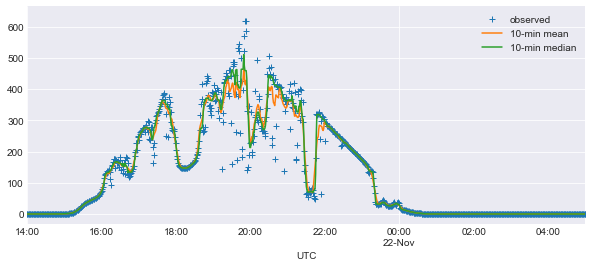

In [66]:
fig,ax = plt.subplots(figsize=(10,4))
PS7['E'].plot(ax=ax,ls='none',marker='+',label='observed')
srad_10min_mean.plot(ax=ax,label='10-min mean')
srad_10min_median.plot(ax=ax,label='10-min median')
#ax.set_xlim((pd.to_datetime('2016-11-21 17:00'),pd.to_datetime('2016-11-22 05:00')))
ax.set_xlim((pd.to_datetime('2016-11-21 14:00'),pd.to_datetime('2016-11-22 05:00')))
ax.legend()

## Read Siemens' lidar data (processed by Mithu)
converted with /Users/equon/WFIP2/Siemens/process_siemens_lidar_matlab.ipynb

In [67]:
lidar = pd.read_csv('Siemens/Siemens_Nov2016_10min.csv')
lidar['datetime'] = pd.to_datetime(lidar['datetime'])
lidar = lidar.set_index('datetime')

calculate shear

In [68]:
speed_table = lidar.pivot(columns='height',values='speed')

In [69]:
lidar_shear_10min = pd.Series(name='shear', index=speed_table.index)

for tstamp,rowdata in speed_table.iterrows():
    rowdata = rowdata[rowdata.notna()]
    if len(rowdata) < 2:
        print('Skipping',tstamp)
        alpha = np.nan
    elif zref not in rowdata.index:
        print('Skipping',tstamp,'(no U at zref)')
        alpha = np.nan
    else:
        zfit = np.array(rowdata.index)
        Ufit = rowdata.values
        alpha, R2 = fit_power_law_alpha(zfit, Ufit, zref=zref, Uref=rowdata[zref])
        if R2 < R2_min:
            alpha = np.nan
        #print(tstamp,len(Ufit),alpha,R2)
    lidar_shear_10min[tstamp] = alpha
    #print(tstamp,len(rowdata),rowdata)

('Skipping', Timestamp('2016-11-15 12:59:59'), '(no U at zref)')
('Skipping', Timestamp('2016-11-15 15:19:59'))
('Skipping', Timestamp('2016-11-16 05:20:00'), '(no U at zref)')


## Read sodar data from PS01

In [70]:
sodar = wfip2.read_dir(dpath=ps01_dpath,
                       reader=pd.read_csv,
                       prefix=ps01_prefix,
                       ext=ps01_ext,
                       parse_dates=['date_time'])

In [71]:
sodar = sodar.set_index('date_time')

In [72]:
sodar.head()

,height,direction,speed,vert,turbulence
date_time,,,,,
2016-11-01,40,293.3,3.32,0.05,0.08
2016-11-01,50,292.1,3.46,0.04,0.06
2016-11-01,60,292.4,3.47,0.04,0.09
2016-11-01,80,291.9,3.62,0.05,0.06
2016-11-01,100,292.2,3.51,0.05,NaN


In [73]:
sodar['height'].unique()

array([ 40,  50,  60,  80, 100, 120, 140, 160, 180, 200])

calculate shear

In [74]:
sodar_speed_table = sodar.pivot(columns='height',values='speed')

In [75]:
%%time
sodar_shear_10min = pd.Series(name='shear', index=sodar_speed_table.index)

for tstamp,rowdata in sodar_speed_table.iterrows():
    rowdata = rowdata[rowdata.notna()]
    if len(rowdata) < 2:
        print('Skipping',tstamp)
        alpha = np.nan
    elif zref not in rowdata.index:
        print('Skipping',tstamp,'(no U at zref)')
        alpha = np.nan
    else:
        zfit = np.array(rowdata.index)
        Ufit = rowdata.values
        alpha, R2 = fit_power_law_alpha(zfit, Ufit, zref=zref, Uref=rowdata[zref])
        if R2 < R2_min:
            alpha = np.nan
        #print(tstamp,len(Ufit),alpha,R2)
    sodar_shear_10min[tstamp] = alpha
    #print(tstamp,len(rowdata),rowdata)

('Skipping', Timestamp('2016-11-01 03:00:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-01 03:10:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-01 03:20:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-01 03:30:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-01 03:40:00'))
('Skipping', Timestamp('2016-11-01 03:50:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-01 04:00:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-01 04:30:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-01 04:40:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-01 04:50:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-01 07:00:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-02 05:10:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-02 05:20:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-02 05:30:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-02 06:40:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-02 06:50:00

('Skipping', Timestamp('2016-11-13 18:10:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-13 18:20:00'))
('Skipping', Timestamp('2016-11-14 02:00:00'))
('Skipping', Timestamp('2016-11-14 02:10:00'))
('Skipping', Timestamp('2016-11-14 02:50:00'))
('Skipping', Timestamp('2016-11-14 03:00:00'))
('Skipping', Timestamp('2016-11-14 03:10:00'))
('Skipping', Timestamp('2016-11-14 03:20:00'))
('Skipping', Timestamp('2016-11-14 03:30:00'))
('Skipping', Timestamp('2016-11-14 03:40:00'))
('Skipping', Timestamp('2016-11-14 03:50:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-14 06:50:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-14 07:00:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-14 07:10:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-14 07:20:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-14 12:30:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-15 02:10:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-15 02:20:00'))
('Skipping

('Skipping', Timestamp('2016-11-29 23:30:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-29 23:40:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-29 23:50:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-30 00:00:00'))
('Skipping', Timestamp('2016-11-30 00:10:00'))
('Skipping', Timestamp('2016-11-30 00:20:00'))
('Skipping', Timestamp('2016-11-30 00:30:00'))
('Skipping', Timestamp('2016-11-30 00:40:00'))
('Skipping', Timestamp('2016-11-30 00:50:00'))
('Skipping', Timestamp('2016-11-30 01:00:00'))
('Skipping', Timestamp('2016-11-30 01:10:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-30 01:20:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-30 01:40:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-30 01:50:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-30 02:00:00'))
('Skipping', Timestamp('2016-11-30 02:10:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-30 02:50:00'), '(no U at zref)')
('Skipping', Timestamp('2016-11-30 03:0

## Read radar data from Wasco

In [76]:
# by default, ESRL_wind_profiler expects a "WINDS" input
# need to set RASS-specific number of returns and the correct columns to QC
radar = wfip2.read_dir(dpath=radar_dpath,
                       reader=remote_sensing.ESRL_wind_profiler,
                       ext=radar_wind_ext,
                       modes=2,check_na=['SPD','DIR','SNR'],na_values=[999999,-980.0])

In [77]:
radar = radar.set_index('date_time')

In [78]:
# FIX for plotting bug
# https://github.com/pandas-dev/pandas/issues/18467
radar.index = radar.index.round('1min')

In [79]:
radar = radar.loc[(radar.index >= plotstart) & (radar.index <= plotend)]

In [80]:
radar.head()

,HT,SPD,DIR,MET_QC,RAD.0,RAD.1,RAD.2,CNT.0,CNT.1,CNT.2,SNR.0,SNR.1,SNR.2,QC.0,QC.1,QC.2
date_time,,,,,,,,,,,,,,,,
2016-11-21 17:00:00,0.081,3.2,246.0,0.0,0.1,1.0,0.8,9.0,9.0,9.0,-3.0,1.0,3.0,0.0,0.0,0.0
2016-11-21 17:00:00,0.138,3.5,242.0,0.0,0.1,1.2,0.8,9.0,9.0,9.0,-5.0,0.0,3.0,0.0,0.0,0.0
2016-11-21 17:00:00,0.196,3.4,246.0,0.0,0.1,1.1,0.8,9.0,9.0,9.0,-13.0,-4.0,-4.0,0.0,0.0,0.0
2016-11-21 17:00:00,0.253,3.8,256.0,0.0,0.1,1.0,1.1,9.0,9.0,9.0,-14.0,-8.0,-6.0,0.0,0.0,0.0
2016-11-21 17:00:00,0.310,3.7,270.0,0.0,0.2,0.7,1.3,9.0,9.0,9.0,-12.0,-8.0,-7.0,0.0,0.0,0.0


calculate shear

In [81]:
radar_speed_table = radar.pivot(columns='HT',values='SPD')

In [82]:
radar_speed_table.head()

HT,0.081,0.138,0.187,0.196,0.253,0.284,0.31,0.367,0.381,0.425,...,5.147,5.244,5.342,5.439,5.536,5.634,5.731,5.828,5.925,6.023
date_time,,,,,,,,,,,,,,,,,,,,,
2016-11-21 17:00:00,3.2,3.5,3.4,3.4,3.8,4.2,3.7,4.7,6.7,5.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-21 18:00:00,4.1,4.9,5.8,5.7,5.7,6.2,5.6,5.8,7.0,6.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-21 19:00:00,5.8,6.0,5.4,6.1,5.9,5.4,6.1,5.9,7.2,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-21 20:00:00,6.1,6.2,7.0,6.4,6.4,7.9,6.5,7.0,9.7,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-21 21:00:00,7.1,7.0,8.0,7.5,8.9,8.7,9.4,9.9,9.3,9.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
radar_speed_table = radar_speed_table[radar['HT'].unique()[:4]] # select 4 heights (up to 253 m)

In [84]:
radar_shear = pd.Series(name='shear', index=radar_speed_table.index)

zref_radar = 0.081

for tstamp,rowdata in radar_speed_table.iterrows():
    rowdata = rowdata[rowdata.notna()]
    if len(rowdata) < 2:
        print('Skipping',tstamp)
        alpha = np.nan
    elif zref_radar not in rowdata.index:
        print('Skipping',tstamp,'(no U at zref)')
        alpha = np.nan
    else:
        zfit = np.array(rowdata.index)
        Ufit = rowdata.values
        alpha, R2 = fit_power_law_alpha(zfit, Ufit, zref=zref_radar, Uref=rowdata[zref_radar])
        if R2 < R2_min:
            alpha = np.nan
        #print(tstamp,len(Ufit),alpha,R2)
    radar_shear[tstamp] = alpha
    #print(tstamp,len(rowdata),rowdata)

In [85]:
radar_shear

date_time
2016-11-21 17:00:00    0.125764
2016-11-21 18:00:00    0.322354
2016-11-21 19:00:00         NaN
2016-11-21 20:00:00    0.044780
2016-11-21 21:00:00    0.126263
2016-11-21 22:00:00    0.024453
2016-11-21 23:00:00    0.088095
2016-11-22 00:00:00         NaN
2016-11-22 01:00:00    0.339601
2016-11-22 02:00:00    0.316986
2016-11-22 03:00:00    0.375274
2016-11-22 04:00:00    0.089014
2016-11-22 05:00:00         NaN
Name: shear, dtype: float64

## Estimate terrain-corrected richardson? (modified BRN?)

## Check turbine wind speeds

In [86]:
pc = pd.read_csv(power_curves)

In [87]:
pc.head()

,bin_name,power_bin_kw,windspeed_bin_ms,id
0,"(0.0, 0.5]",0.003357,0.25,tower301
1,"(0.5, 1.0]",0.061605,0.75,tower301
2,"(1.0, 1.5]",0.474585,1.25,tower301
3,"(1.5, 2.0]",2.373795,1.75,tower301
4,"(2.0, 2.5]",14.198720,2.25,tower301


In [88]:
tid = 'tower301'
turb = pc.loc[pc['id']==tid]
scada = plant.scada.df.set_index(tindex)
scada = scada.loc[scada['id']==tid]
scada = scada.resample('1min').mean().interpolate()
scadawind = scada['windspeed_ms']

In [89]:
#WS_from_PC = np.interp(scada['power_kw'], pc['power_bin_kw'], pc['windspeed_bin_ms'])
WS_from_PC = np.interp(scada['power_kw'], pc['power_bin_kw'], pc['windspeed_bin_ms'], left=np.nan, right=np.nan)

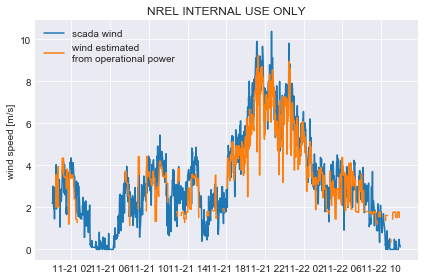

In [90]:
fig,ax = plt.subplots()
ax.plot(scada.index, scadawind, label='scada wind')
ax.plot(scada.index, WS_from_PC, label='wind estimated\nfrom operational power')
ax.set_ylabel('wind speed [m/s]')
ax.legend(loc='best')
ax.set_title('NREL INTERNAL USE ONLY')

plt.tight_layout()
fig.savefig('/Users/equon/WFIP2/PGE/windspeed_comparison.png',dpi=150)

In [91]:
selected = np.isfinite(WS_from_PC) & (WS_from_PC >= 4.0)
WS_scada_selected = scadawind.loc[selected]
WS_PCest_selected = WS_from_PC[selected]

/Users/equon/miniconda2/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


In [92]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(WS_scada_selected,WS_PCest_selected)
R2 = r_value**2
print(slope,intercept,R2)

(0.73136588247935519, 1.257131145244486, 0.7468365052699738)


In [93]:
coef, resid, rank, svals = np.linalg.lstsq(WS_scada_selected[:,np.newaxis],WS_PCest_selected)
ffit = coef[0]*WS_scada_selected
SSres = np.sum((WS_PCest_selected - ffit)**2)
SStot = np.sum((WS_PCest_selected - np.mean(WS_PCest_selected))**2)
R2_0 = 1 - SSres/SStot

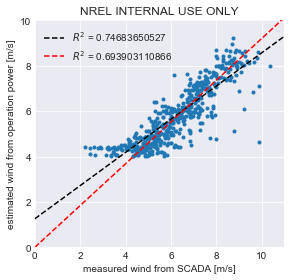

In [94]:
fig,ax = plt.subplots()

ax.scatter(WS_scada_selected, WS_PCest_selected, marker='.')
ax.set_xlabel('measured wind from SCADA [m/s]')
ax.set_ylabel('estimated wind from operation power [m/s]')
ax.set_title('NREL INTERNAL USE ONLY')

ax.plot([0,11],[intercept,intercept+11*slope],'k--',label=r'$R^2$ = {}'.format(R2))
ax.plot([0,11],[0,11*coef[0]],'r--',label=r'$R^2$ = {}'.format(R2_0))

ax.legend(loc='upper left')
ax.axis('scaled')
ax.set_xlim((0,11))
ax.set_ylim((0,10))

plt.tight_layout()
fig.savefig('/Users/equon/WFIP2/PGE/windspeed_correlation.png',dpi=150)

/Users/equon/miniconda2/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


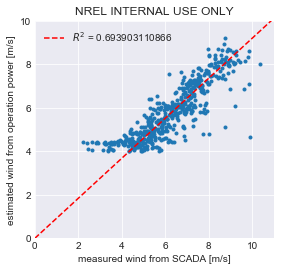

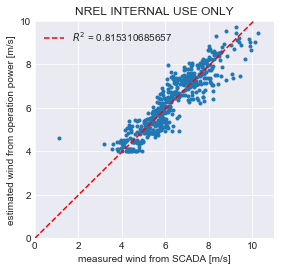

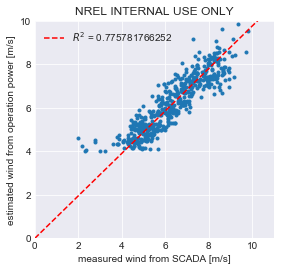

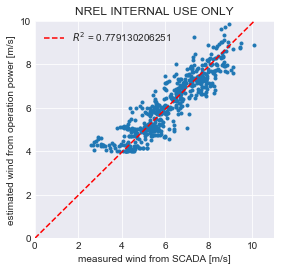

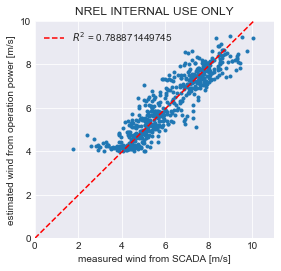

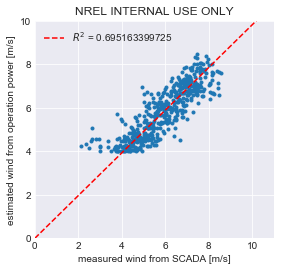

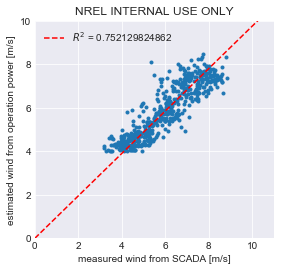

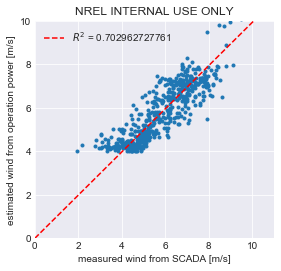

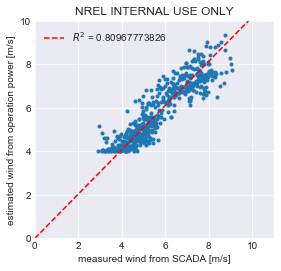

In [95]:
R2_values = []
for tid in range(1,10):
    tid = 'tower' + str(300+tid)
    
    scada = plant.scada.df.set_index(tindex)
    scada = scada.loc[scada['id']==tid]
    scada = scada.resample('1min').mean().interpolate()
    scadawind = scada['windspeed_ms']
    
    WS_from_PC = np.interp(scada['power_kw'], pc['power_bin_kw'], pc['windspeed_bin_ms'], left=np.nan, right=np.nan)    
    selected = np.isfinite(WS_from_PC) & (WS_from_PC >= 4.0)
    WS_scada_selected = scadawind.loc[selected]
    WS_PCest_selected = WS_from_PC[selected]
    
    coef, resid, rank, svals = np.linalg.lstsq(WS_scada_selected[:,np.newaxis],WS_PCest_selected)
    ffit = coef[0]*WS_scada_selected
    SSres = np.sum((WS_PCest_selected - ffit)**2)
    SStot = np.sum((WS_PCest_selected - np.mean(WS_PCest_selected))**2)
    R2 = 1 - SSres/SStot
    R2_values.append(R2)
    
    fig,ax = plt.subplots()
    ax.scatter(WS_scada_selected, WS_PCest_selected, marker='.')
    ax.set_xlabel('measured wind from SCADA [m/s]')
    ax.set_ylabel('estimated wind from operation power [m/s]')
    ax.set_title('NREL INTERNAL USE ONLY')
    ax.plot([0,11],[0,11*coef[0]],'r--',label=r'$R^2$ = {}'.format(R2))
    ax.legend(loc='upper left')
    ax.axis('scaled')
    ax.set_xlim((0,11))
    ax.set_ylim((0,10))

In [96]:
np.min(R2_values), np.max(R2_values)

(0.69390311086560041, 0.8153106856570288)

## PLOTS

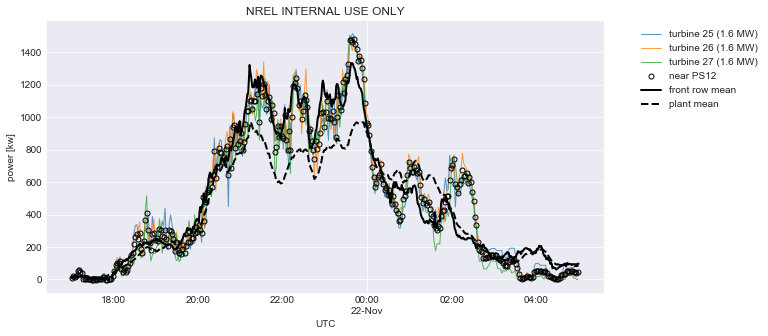

In [97]:
selected_turbines = [25,26,27] # downwind of PS12
plotstart = pd.to_datetime('2016-11-21 17:00')
plotend = pd.to_datetime('2016-11-22 05:00')

fig,ax = plt.subplots(figsize=(10,5))
nearPS12_mean_output = None
for tid in selected_turbines:
    turbname = 'tower{:03d}'.format(tid)
    df = plant.scada.df.set_index(tindex)
    timerange = (df.index >= plotstart) & (df.index <= plotend)
    select = (df['id'] == turbname) & timerange
    ratedMW = plant.asset.df.query("id == '"+turbname+"'")['rated_power_kw'] / 1000.
    Poutput = df.loc[select,'power_kw']
    Poutput.plot(lw=1,alpha=0.75,label='turbine {:d} ({:.1f} MW)'.format(tid,float(ratedMW)))
    try: 
        nearPS12_mean_output += Poutput
    except TypeError: 
        nearPS12_mean_output = Poutput

nearPS12_mean_output /= len(selected_turbines)
nearPS12_mean_output.plot(color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='near PS12')

timerange = (front_row_mean.index >= plotstart) & (front_row_mean.index <= plotend)
front_row_mean.loc[timerange].plot(ls='-',lw=2,color='k',label='front row mean')

timerange = (scada_1min.index >= plotstart) & (scada_1min.index <= plotend)
scada_1min['power_kw'].loc[timerange].plot(ls='--',lw=2,color='k',label='plant mean')

#ax.xaxis.set_major_locator(mdates.HourLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#ax.set_xlabel('local time ['+timezone_str+']')
#ax.set_title('2016-11-21')
#ax.set_xlabel('local time (2016-11-21)')
ax.set_ylabel('power [kw]')
legend = ax.legend(loc='upper left',bbox_to_anchor=(1.05,1))

ax.set_title('NREL INTERNAL USE ONLY')

fig.savefig('power_nearPS12.png',dpi=150,bbox_extra_artists=(legend,),bbox_inches='tight')

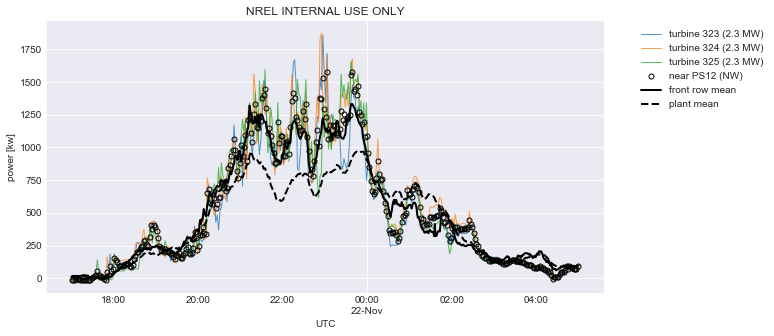

In [98]:
selected_turbines = [323,324,325] # turbines, NW of PS12

fig,ax = plt.subplots(figsize=(10,5))
control_mean_output = None
for tid in selected_turbines:
    turbname = 'tower{:03d}'.format(tid)
    df = plant.scada.df.set_index(tindex)
    timerange = (df.index >= plotstart) & (df.index <= plotend)
    select = (df['id'] == turbname) & timerange
    ratedMW = plant.asset.df.query("id == '"+turbname+"'")['rated_power_kw'] / 1000.
    Poutput = df.loc[select,'power_kw']
    Poutput.plot(lw=1,alpha=0.75,label='turbine {:d} ({:.1f} MW)'.format(tid,float(ratedMW)))
    try: 
        control_mean_output += Poutput
    except TypeError: 
        control_mean_output = Poutput

control_mean_output /= len(selected_turbines)
control_mean_output.plot(color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='near PS12 (NW)')

timerange = (front_row_mean.index >= plotstart) & (front_row_mean.index <= plotend)
front_row_mean.loc[timerange].plot(ls='-',lw=2,color='k',label='front row mean')

timerange = (scada_1min.index >= plotstart) & (scada_1min.index <= plotend)
scada_1min['power_kw'].loc[timerange].plot(ls='--',lw=2,color='k',label='plant mean')

#ax.xaxis.set_major_locator(mdates.HourLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#ax.set_xlabel('local time ['+timezone_str+']')
#ax.set_title('2016-11-21')
#ax.set_xlabel('local time (2016-11-21)')
ax.set_ylabel('power [kw]')
legend = ax.legend(loc='upper left',bbox_to_anchor=(1.05,1))

ax.set_title('NREL INTERNAL USE ONLY')

fig.savefig('power_control.png',dpi=150,bbox_extra_artists=(legend,),bbox_inches='tight')

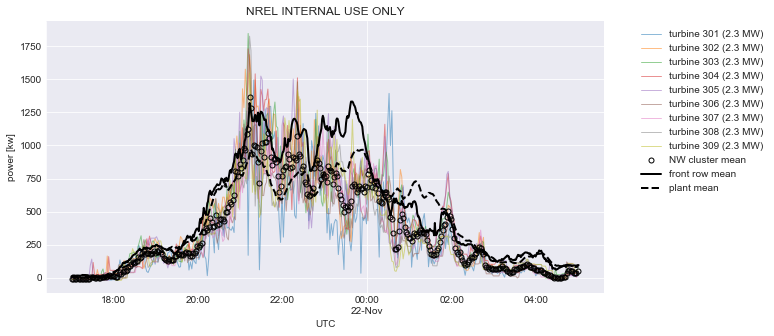

In [99]:
selected_turbines = range(301,310) # NW cluster: tower301-309
plotstart = pd.to_datetime('2016-11-21 17:00')
plotend = pd.to_datetime('2016-11-22 05:00')

fig,ax = plt.subplots(figsize=(10,5))
mean_output = None
mean_wspd = None
mean_wdir = None
mean1_output = None # front of NW cluster
mean1_wspd = None
mean1_wdir = None
for tid in selected_turbines:
    turbname = 'tower' + str(tid)
    df = plant.scada.df.set_index(tindex)
    timerange = (df.index >= plotstart) & (df.index <= plotend)
    select = (df['id'] == turbname) & timerange
    ratedMW = plant.asset.df.query("id == '"+turbname+"'")['rated_power_kw'] / 1000.
    Poutput = df.loc[select,'power_kw']
    Poutput.plot(lw=1,alpha=0.5,label='turbine {:d} ({:.1f} MW)'.format(tid,float(ratedMW)))
    try: 
        mean_output += Poutput
        mean_wspd += df.loc[select,'windspeed_ms']
        mean_wdir += df.loc[select,'winddirection_deg']
        if tid <= 305:
            mean1_output += Poutput
            mean1_wspd += df.loc[select,'windspeed_ms']
            mean1_wdir += df.loc[select,'winddirection_deg']
    except TypeError: 
        mean_output = Poutput.copy()
        mean_wspd = df.loc[select,'windspeed_ms']
        mean_wdir = df.loc[select,'winddirection_deg']
        mean1_output = Poutput.copy()
        mean1_wspd = df.loc[select,'windspeed_ms']
        mean1_wdir = df.loc[select,'winddirection_deg']
# rear row of NW cluster:
mean2_output = mean_output - mean1_output
mean2_wspd = mean_wspd - mean1_wspd
mean2_wdir = mean_wdir - mean1_wdir

# means
mean_output /= len(selected_turbines)
mean_wspd /= len(selected_turbines)
mean_wdir /= len(selected_turbines)
mean1_output /= 5
mean1_wspd /= 5
mean1_wdir /= 5
mean2_output /= 4
mean2_wspd /= 4
mean2_wdir /= 4

mean_output.plot(color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='NW cluster mean')

timerange = (front_row_mean.index >= plotstart) & (front_row_mean.index <= plotend)
front_row_mean.loc[timerange].plot(ls='-',lw=2,color='k',label='front row mean')

timerange = (scada_1min.index >= plotstart) & (scada_1min.index <= plotend)
scada_1min['power_kw'].loc[timerange].plot(ls='--',lw=2,color='k',label='plant mean')

#ax.xaxis.set_major_locator(mdates.HourLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#ax.set_xlabel('local time ['+timezone_str+']')
#ax.set_title('2016-11-21')
#ax.set_xlabel('local time (2016-11-21)')
ax.set_ylabel('power [kw]')
legend = ax.legend(loc='upper left',bbox_to_anchor=(1.05,1))

ax.set_title('NREL INTERNAL USE ONLY')

fig.savefig('power_NWcluster.png',dpi=150,bbox_extra_artists=(legend,),bbox_inches='tight')

In [100]:
radar.loc[radar['HT']==0.081,'SPD'].index

DatetimeIndex(['2016-11-21 17:00:00', '2016-11-21 18:00:00',
               '2016-11-21 19:00:00', '2016-11-21 20:00:00',
               '2016-11-21 21:00:00', '2016-11-21 22:00:00',
               '2016-11-21 23:00:00', '2016-11-22 00:00:00',
               '2016-11-22 01:00:00', '2016-11-22 02:00:00',
               '2016-11-22 03:00:00', '2016-11-22 04:00:00',
               '2016-11-22 05:00:00'],
              dtype='datetime64[ns]', name=u'date_time', freq=None)

In [101]:
front_row_mean.loc[(front_row_mean.index >= plotstart) & (front_row_mean.index <= plotend)]

UTC
2016-11-21 17:00:00+00:00     10.723779
2016-11-21 17:01:00+00:00     14.386957
2016-11-21 17:02:00+00:00     17.940165
2016-11-21 17:03:00+00:00     17.805726
2016-11-21 17:04:00+00:00     18.916109
2016-11-21 17:05:00+00:00     15.174862
2016-11-21 17:06:00+00:00     16.470717
2016-11-21 17:07:00+00:00     17.714583
2016-11-21 17:08:00+00:00     16.813098
2016-11-21 17:09:00+00:00     17.424856
2016-11-21 17:10:00+00:00     16.648330
2016-11-21 17:11:00+00:00     17.358357
2016-11-21 17:12:00+00:00     16.478416
2016-11-21 17:13:00+00:00     16.110295
2016-11-21 17:14:00+00:00     18.432760
2016-11-21 17:15:00+00:00     18.778200
2016-11-21 17:16:00+00:00     18.879313
2016-11-21 17:17:00+00:00     19.380674
2016-11-21 17:18:00+00:00     21.652978
2016-11-21 17:19:00+00:00     18.845093
2016-11-21 17:20:00+00:00     13.870465
2016-11-21 17:21:00+00:00     12.696110
2016-11-21 17:22:00+00:00     11.713424
2016-11-21 17:23:00+00:00      9.780958
2016-11-21 17:24:00+00:00     12.712

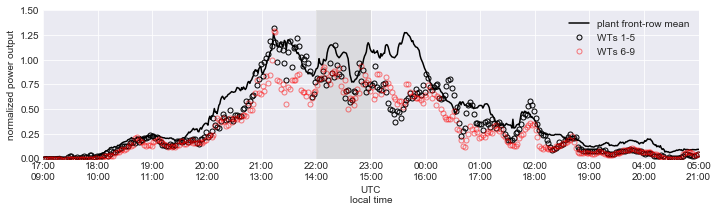

In [102]:
# POWER OUTPUT
fig,ax = plt.subplots(figsize=(10,3))

norm = front_row_mean.loc[(front_row_mean.index >= focusstart) & (front_row_mean.index <= focusend)].mean()

#scada_1min['power_kw'].plot(ax=ax[3],ls='--',color='k',label='plant mean')
front_row_mean_norm = front_row_mean / norm
mean1_output_norm = mean1_output / norm
mean2_output_norm = mean2_output / norm
front_row_mean_norm.plot(color='k',label='plant front-row mean')
mean1_output_norm.plot(color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='WTs 1-5')
mean2_output_norm.plot(color='r',ls='none',marker='o',markersize=5,fillstyle='none',alpha=0.5,label='WTs 6-9')
ax.set_ylabel(r'normalized power output')
ax.set_ylim((0,1.5))

# misc plot formatting
ax.legend(loc='best')

ax = [ax]
clean_up_xaxis(ax)
highlight_period(ax)

# save figure
plt.tight_layout()
fig.savefig('scada_scitech_20161121.png',bbox_inches='tight',dpi=150)

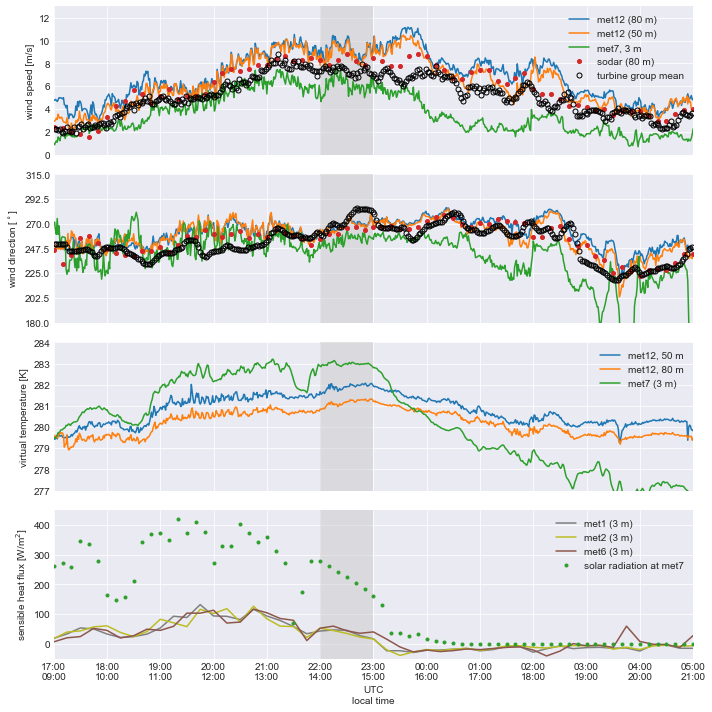

In [103]:
#
# CLEANED UP FOR SCITECH ABSTRACT (June 18, 2018)
#

fig,ax = plt.subplots(nrows=4,sharex=True,figsize=(10,10))

# WIND SPEED
PS12_80m_1min['wind_speed'].plot(ax=ax[0],label='met12 (80 m)')
PS12_50m_1min['wind_speed'].plot(ax=ax[0],label='met12 (50 m)')
PS7['U'].plot(ax=ax[0],label='met7, 3 m')
sodar_selected = (sodar.index >= plotstart) & (sodar.index <= plotend) & (sodar['height'] == 80)
sodar.loc[sodar_selected,'speed'].plot(ax=ax[0],label='sodar (80 m)',
                                       color=colors[3],marker='o',markersize=4,ls='none')
#radar.loc[radar['HT']==0.081,'SPD'].plot(ax=ax[0],color=colors[9],ls='none',marker='^',markersize=8,label='radar, 81 m')
mean_wspd.plot(ax=ax[0],color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='turbine group mean')

ax[0].set_ylabel(r'wind speed [m/s]')
ax[0].set_ylim((0,13))
ax[0].yaxis.set_ticks(np.arange(0,13.1,2))

# WIND DIRECTION
PS12_80m_1min['wind_direction'].plot(ax=ax[1],label='met12 (80 m)')
PS12_50m_1min['wind_direction'].plot(ax=ax[1],label='met12 (50 m)')
PS7['ThetaU'].plot(ax=ax[1],color=colors[2],label='met7, 3 m')
sodar.loc[sodar_selected,'direction'].plot(ax=ax[1],label='sodar (80 m)',
                                          color=colors[3],marker='o',markersize=4,ls='none')
#radar.loc[radar['HT']==0.081,'DIR'].plot(ax=ax[1],color=colors[9],ls='none',marker='^',markersize=8,label='radar, 81 m')
mean_wdir.plot(ax=ax[1],color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='turbine group mean')

ax[1].set_ylabel(r'wind direction [$^\circ$]')
ax[1].yaxis.set_ticks(np.arange(180,315.1,22.5))
ax[1].set_ylim((180,315))

# TEMPERATURE
PS12_50m_1min['temperature'].plot(ax=ax[2],label='met12, 50 m') # sonic virtual temperature
PS12_80m_1min['temperature'].plot(ax=ax[2],label='met12, 80 m') # sonic virtual temperature
(PS7['T']+273.15).plot(ax=ax[2],color=colors[2],label='met7 (3 m)')

#ax[2].yaxis.set_ticks(np.arange(2,11))
#ax[2].set_ylim((3,10.5))
ax[2].set_ylabel(r'virtual temperature [K]')
ax[2].set_ylim((277,284))

# downwelling shortwave solar radiation
PS01.loc[PS01['height']==3,'H'].plot(ax=ax[3],color=colors[7],label='met1 (3 m)')
PS02.loc[PS02['height']==3,'H'].plot(ax=ax[3],color=colors[8],label='met2 (3 m)')
PS06.loc[PS06['height']==3,'H'].plot(ax=ax[3],color=colors[5],label='met6 (3 m)')
rad = PS7['E'].resample('10min').mean()
rad.plot(ax=ax[3],ls='none',marker='.',color=colors[2],label='solar radiation at met7')
ax[3].set_ylabel(r'sensible heat flux [W/m$^2$]')
ax[3].legend()
ax[3].set_ylim((-50,450))

# POWER OUTPUT
# #scada_1min['power_kw'].plot(ax=ax[3],ls='--',color='k',label='plant mean')
# front_row_mean_norm = front_row_mean / 2300
# mean1_output_norm = mean1_output / 2300
# mean2_output_norm = mean2_output / 2300
# front_row_mean_norm.plot(ax=ax[3],color='k',label='plant front-row mean')
# mean1_output_norm.plot(ax=ax[3],color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='WTs 1-5')
# mean2_output_norm.plot(ax=ax[3],color='r',ls='none',marker='o',markersize=5,fillstyle='none',alpha=0.5,label='WTs 6-9')
# ax[3].set_ylabel(r'normalized power output')

# misc plot formatting
ax[0].legend(loc='best')
ax[2].legend(loc='best')
ax[3].legend(loc='best')

clean_up_xaxis(ax)

highlight_period(ax)

# save figure
plt.tight_layout()
fig.savefig('measurements_scitech_20161121.png',bbox_inches='tight',dpi=150)

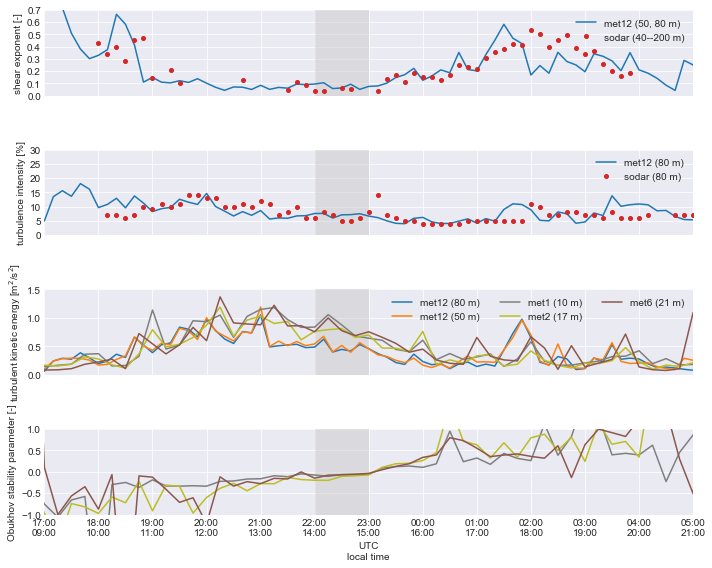

In [104]:
fig,ax = plt.subplots(nrows=4,sharex=True,figsize=(10,8))

# SHEAR
#PS12_shear_1min.plot(ax=ax[0],label='met12')
PS12_shear_1min.resample('10min').mean().plot(ax=ax[0],label='met12 (50, 80 m)')
# PS06_shear.resample('10min').mean().interpolate().plot(ax=ax[0],color=colors[5],label='met6 (21m)')
# PS02_shear.resample('10min').mean().interpolate().plot(ax=ax[0],color=colors[8],label='met2 (17m)')
# PS01_shear.resample('10min').mean().interpolate().plot(ax=ax[0],color=colors[7],label='met1 (10m)')
sodar_selected = sodar_shear_10min.loc[(sodar_shear_10min.index >= plotstart) & (sodar_shear_10min.index <= plotend)]
sodar_selected.plot(ax=ax[0],color=colors[3],marker='o',markersize=4,ls='none',label='sodar (40--200 m)')
#lidar_selected = lidar_shear_10min.loc[(lidar_shear_10min.index >= plotstart) & (lidar_shear_10min.index <= plotend)]
#lidar_selected.plot(ax=ax[0],color=colors[4],marker='s',markersize=4,ls='none',label='lidar')
#radar_shear.plot(ax=ax[0],color=colors[9],marker='^',markersize=4,ls='none',label='radar')

ax[0].set_ylabel(r'shear exponent [-]')
#ax[0].set_ylim((0,0.8)) # shear
ax[0].set_ylim((0,0.7)) # shear
ax[0].yaxis.set_ticks(np.arange(0,0.71,0.1))

# TI
PS12_80m_1min['TI_pct'].resample('10min').mean().plot(ax=ax[1],label='met12 (80 m)')
#PS12_50m_1min['TI_pct'].plot(ax=ax[1],label='met12, 50 m')
#PS12_80m_1min['TIxy_pct'].resample('10min').mean().plot(ax=ax[1],ls='--',color=ax[0].get_lines()[0].get_color(),label='')
#PS12_50m_1min['TIxy_pct'].plot(ax=ax[1],ls='--',color=ax[0].get_lines()[1].get_color(),label='')
TI_sodar = sodar['turbulence'] * 100
TI_sodar.loc[sodar['height']==80].plot(ax=ax[1],color=colors[3],marker='o',markersize=4,ls='none',label='sodar (80 m)')
#lidar.loc[lidar['height']==80,'TI'].plot(ax=ax[1],color=colors[4],marker='s',markersize=4,ls='none',label='lidar')

ax[1].set_ylim((0,30)) # TI
ax[1].yaxis.set_ticks(np.arange(0,31,5))
ax[1].set_ylabel(r'turbulence intensity [%]')

# TKE
PS12_80m_1min['TKE'].resample('10min').mean().plot(ax=ax[2],label='met12 (80 m)')
PS12_50m_1min['TKE'].resample('10min').mean().plot(ax=ax[2],label='met12 (50 m)')
#PS11['TKE'].plot(ax=ax[2],color=colors[8],label='met11 (10 m')
PS01.loc[PS01['height']==10,'TKE'].plot(ax=ax[2],color=colors[7],label='met1 (10 m)')
PS02.loc[PS02['height']==17,'TKE'].plot(ax=ax[2],color=colors[8],label='met2 (17 m)')
PS06.loc[PS06['height']==21,'TKE'].plot(ax=ax[2],color=colors[5],label='met6 (21 m)')

ax[2].set_ylabel(r'turbulent kinetic energy [m$^2$/s$^2$]')
ax[2].set_ylim((0,1.5))

# Obukhov stability
#PS11['(z-d)/L'].plot(ax=ax[3],color=colors[8],label='met11 (10 m)')
PS01.loc[PS01['height']==10,'(z-d)/L'].plot(ax=ax[3],color=colors[7],label='met1 (10 m)')
PS02.loc[PS02['height']==17,'(z-d)/L'].plot(ax=ax[3],color=colors[8],label='met2 (17 m)')
PS06.loc[PS06['height']==21,'(z-d)/L'].plot(ax=ax[3],color=colors[5],label='met6 (21 m)')
ax[3].set_ylabel(r'Obukhov stability parameter [-]')
#ax[3].set_ylim((-2,2))
ax[3].set_ylim((-1,1))

# misc plot formatting
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best',ncol=3)

clean_up_xaxis(ax)

highlight_period(ax)

# save figure
plt.tight_layout()
fig.savefig('calculations_scitech_20161121.png',bbox_inches='tight',dpi=150)

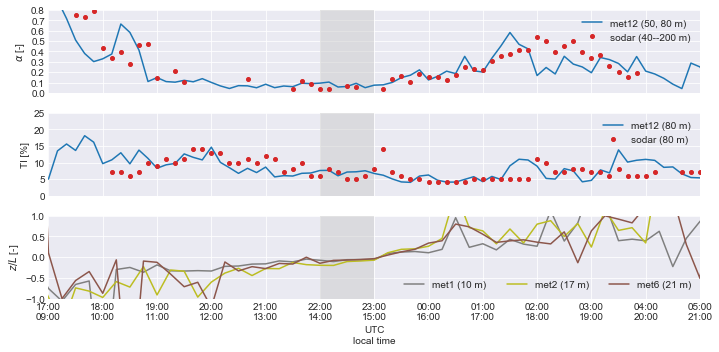

In [105]:
#
# FOR PRESENTATION SLIDE
#
fig,ax = plt.subplots(nrows=3,sharex=True,figsize=(10,5))

# SHEAR
PS12_shear_1min.resample('10min').mean().plot(ax=ax[0],label='met12 (50, 80 m)')
sodar_selected = sodar_shear_10min.loc[(sodar_shear_10min.index >= plotstart) & (sodar_shear_10min.index <= plotend)]
sodar_selected.plot(ax=ax[0],color=colors[3],marker='o',markersize=4,ls='none',label='sodar (40--200 m)')

ax[0].set_ylabel(r'$\alpha$ [-]')
ax[0].set_ylim((0,0.8)) # shear
ax[0].yaxis.set_ticks(np.arange(0,0.81,0.1))

# TI
PS12_80m_1min['TI_pct'].resample('10min').mean().plot(ax=ax[1],label='met12 (80 m)')
TI_sodar = sodar['turbulence'] * 100
TI_sodar.loc[sodar['height']==80].plot(ax=ax[1],color=colors[3],marker='o',markersize=4,ls='none',label='sodar (80 m)')

ax[1].set_ylim((0,25)) # TI
ax[1].yaxis.set_ticks(np.arange(0,26,5))
ax[1].set_ylabel(r'TI [%]')

# Obukhov stability
PS01.loc[PS01['height']==10,'(z-d)/L'].plot(ax=ax[2],color=colors[7],label='met1 (10 m)')
PS02.loc[PS02['height']==17,'(z-d)/L'].plot(ax=ax[2],color=colors[8],label='met2 (17 m)')
PS06.loc[PS06['height']==21,'(z-d)/L'].plot(ax=ax[2],color=colors[5],label='met6 (21 m)')
ax[2].set_ylabel(r'$z/L$ [-]')
ax[2].set_ylim((-1,1))

# misc plot formatting
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best',ncol=3)

clean_up_xaxis(ax)

highlight_period(ax)

# save figure
plt.tight_layout()
fig.savefig('shear_TI_Obukhov_20161121.png',bbox_inches='tight',dpi=150)

In [142]:
PS01['height'].unique(),PS02['height'].unique(),PS06['height'].unique()

(array([  3.,  10.]), array([  3.,  10.,  17.]), array([  3.,  10.,  21.]))

(24662700, 24662880)

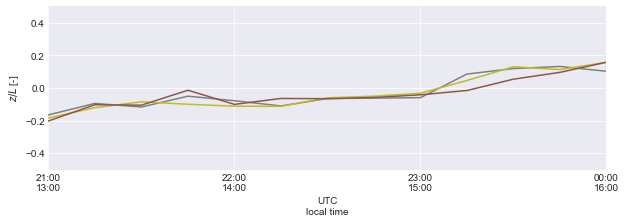

In [143]:
fig,ax = plt.subplots(figsize=(10,3))
PS01.loc[PS01['height']==10,'(z-d)/L'].plot(ax=ax,color=colors[7],label='met1 (10 m)')
PS02.loc[PS02['height']==10,'(z-d)/L'].plot(ax=ax,color=colors[8],label='met2 (17 m)')
PS06.loc[PS06['height']==10,'(z-d)/L'].plot(ax=ax,color=colors[5],label='met6 (21 m)')
ax.set_ylabel(r'$z/L$ [-]')
ax.set_ylim((-.5,.5))
clean_up_xaxis([ax])
ax.set_xlim(('2016-11-21 21:00','2016-11-22 00:00'))

In [148]:
z_L = pd.DataFrame({
    'PS01': PS01.loc[PS01['height']==10,'(z-d)/L'],
    'PS02': PS02.loc[PS02['height']==10,'(z-d)/L'],
    'PS06': PS06.loc[PS06['height']==10,'(z-d)/L'],
})

In [155]:
period = (z_L.index >= '2016-11-21 22:00') & (z_L.index <= '2016-11-21 23:00')
z_L.loc[period].min().min(), z_L.loc[period].max().max()

(-0.1126415477702688, -0.032046003356319873)

## Wind speed profiles

[ 40  50  60  80 100 120 140 160 180 200]
[ 50  65  75  80 100 125 150 175 200 225 250 275 300 400]
[   81.   138.   187.   196.   253.   284.   310.   367.   381.   425.
   478.   482.   539.   576.   596.   653.   673.   711.   768.   770.
   825.   867.   882.   939.   965.   997.  1054.  1062.  1111.  1159.
  1168.  1226.  1256.  1283.  1340.  1354.  1397.  1451.  1454.  1512.
  1548.  1569.  1626.  1646.  1683.  1741.  1743.  1798.  1840.  1855.
  1912.  1937.  1969.  2027.  2035.  2084.  2132.  2141.  2198.  2229.
  2255.  2313.  2326.  2370.  2424.  2427.  2484.  2521.  2542.  2618.
  2716.  2813.  2910.  3007.  3105.  3202.  3299.  3396.  3494.  3591.
  3688.  3785.  3883.  3980.  4077.  4175.  4272.  4369.  4466.  4564.
  4661.  4758.  4855.  4953.  5050.  5147.  5244.  5342.  5439.  5536.
  5634.  5731.  5828.  5925.  6023.]


(0, 3000)

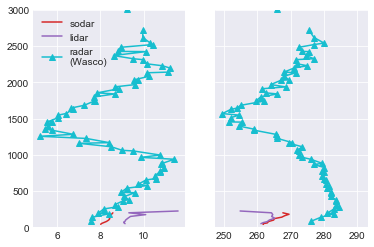

In [107]:
#fig,ax = plt.subplots()
fig,ax = plt.subplots(ncols=2,sharey=True)

selected = sodar.loc[(sodar.index >= focusstart) & (sodar.index <= focusend)]
WS = selected.pivot(columns='height',values='speed')
WD = selected.pivot(columns='height',values='direction')
z = np.array(WS.columns)
print(z)
# for tstamp, rowdata in pivoted.iterrows():
#     print(tstamp)
#     ax.plot(rowdata.values, z, color=colors[3])
ax[0].plot(WS.mean(axis=0), z, color=colors[3], label='sodar')
ax[1].plot(WD.mean(axis=0), z, color=colors[3], label='sodar')

selected = lidar.loc[(lidar.index >= focusstart) & (lidar.index <= focusend)]
WS = selected.pivot(columns='height',values='speed')
WD = selected.pivot(columns='height',values='direction')
z = np.array(WS.columns)
print(z)
# for tstamp, rowdata in pivoted.iterrows():
#     print(tstamp)
#     ax.plot(rowdata.values, z, color=colors[4])
ax[0].plot(WS.mean(axis=0), z, color=colors[4], label='lidar')
ax[1].plot(WD.mean(axis=0), z, color=colors[4], label='lidar')
    
selected = radar.loc[(radar.index >= focusstart) & (radar.index <= focusend)]
WS = selected.pivot(columns='HT',values='SPD')
WD = selected.pivot(columns='HT',values='DIR')
z = 1000*np.array(WS.columns)
print(z)
# for tstamp, rowdata in pivoted.iterrows():
#     print(tstamp)
#     ax.plot(rowdata.values, z, color=colors[9], marker='^')
ax[0].plot(WS.mean(axis=0), z, color=colors[9], marker='^', label='radar\n(Wasco)')
ax[1].plot(WD.mean(axis=0), z, color=colors[9], marker='^', label='radar\n(Wasco)')

ax[0].legend(loc='best')
ax[0].set_ylim((0,3000))

## Get target values in focus period

In [108]:
# 80-m met mast
focus_range = (PS12_80m_1min.index >= focusstart) & (PS12_80m_1min.index <= focusend)
focus_trange = PS12_80m_1min.index[focus_range]
focus_wspd = PS12_80m_1min.loc[focus_range,'wind_speed'].mean()
focus_wdir = PS12_80m_1min.loc[focus_range,'wind_direction'].mean()
focus_TI = PS12_80m_1min.loc[focus_range,'TI_pct'].mean()
focus_TI_min = PS12_80m_1min.loc[focus_range,'TI_pct'].min()
focus_TI_max = PS12_80m_1min.loc[focus_range,'TI_pct'].max()
focus_TIxy = PS12_80m_1min.loc[focus_range,'TIxy_pct'].mean()
focus_TIxy_min = PS12_80m_1min.loc[focus_range,'TIxy_pct'].min()
focus_TIxy_max = PS12_80m_1min.loc[focus_range,'TIxy_pct'].max()
focus_shear = PS12_shear_1min[focus_range].mean()
focus_shear_min = PS12_shear_1min[focus_range].min()
focus_shear_max = PS12_shear_1min[focus_range].max()

# SCADA
focus_range = (mean_wspd.index >= focusstart) & (mean_wspd.index <= focusend)
focus_wspd_turb = mean_wspd.loc[focus_range].mean()
focus_wdir_turb = mean_wdir.loc[focus_range].mean()

# PS7
focus_range = (PS7.index >= focusstart) & (PS7.index <= focusend)
focus_rad = PS7['E'].loc[focus_range].mean()
focus_rad_min = PS7['E'].loc[focus_range].min()
focus_rad_max = PS7['E'].loc[focus_range].max()

print('time range START',focus_trange[0])
print('time range END',focus_trange[-1])
print('PS12 wind',focus_wspd, focus_wdir)
print('SCADA wind',focus_wspd_turb, focus_wdir_turb)
print('streamwise TI range',focus_TIxy_min, focus_TIxy, focus_TIxy_max)
print('cup-equivalent TI range',focus_TI_min, focus_TI, focus_TI_max)
print('shear range',focus_shear_min, focus_shear, focus_shear_max)
print('solar radiation',focus_rad_min, focus_rad, focus_rad_max)

('time range START', Timestamp('2016-11-21 22:00:00+0000', tz='UTC', freq='T'))
('time range END', Timestamp('2016-11-21 23:00:00+0000', tz='UTC', freq='T'))
('PS12 wind', 9.1945252431119791, 267.88167389207962)
('SCADA wind', 7.3784436069646295, 274.2427545933333)
('streamwise TI range', 5.5508909142950822, 7.2442616354954188, 9.7837585606670636)
('cup-equivalent TI range', 5.516150263296856, 7.1898652949763262, 9.7468156373592905)
('shear range', 0.0013567326470765521, 0.078990439261293302, 0.21305590611442282)
('solar radiation', 171.90000000000001, 231.17377049180328, 293.0)


In [109]:
# potential temp corresponding to 10 deg C at 475-m elevation
(10 + 273.15) + 0.0098*475

287.80499999999995

In [110]:
plant.asset.parse_geometry()

In [111]:
IDs = ['PS12']
turbinelist = [301,302,303,304,305,306,307,308,309,323,324,325]
IDs += [ 'tower'+str(i) for i in turbinelist ]
plant.asset.df['dummy'] = 0
utm_coords_list = plant.asset.df.pivot(index='dummy',columns='id',values='geometry')[IDs]

In [112]:
x,y = [], []
for asset,coords in utm_coords_list.iteritems():
    x.append(coords[0].x)
    y.append(coords[0].y)
    print(asset,x[-1],y[-1])
x = np.array(x)
y = np.array(y)

('PS12', 683695.4958774024, 5056530.623545486)
('tower301', 680615.9324808598, 5060111.516606138)
('tower302', 680713.736995169, 5059843.487500689)
('tower303', 680759.3447758816, 5059539.477017313)
('tower304', 680944.1509652142, 5059264.077010044)
('tower305', 681164.930536689, 5059023.084011824)
('tower306', 681633.220459319, 5059972.944299243)
('tower307', 681814.7328503085, 5059712.5946381455)
('tower308', 681887.8781540908, 5059503.461324126)
('tower309', 682221.4804961194, 5059300.709885553)
('tower323', 682489.5581160185, 5057598.952901245)
('tower324', 682577.7673130727, 5057308.205837727)
('tower325', 682729.8269798773, 5057063.917211539)


In [113]:
x -= x[0]
y -= y[0]

In [114]:
for i,asset in enumerate(IDs):
    #print(asset,x[i],y[i])
    print('{:s} {:g} {:g}'.format(asset,x[i],y[i]))

PS12 0 0
tower301 -3079.56 3580.89
tower302 -2981.76 3312.86
tower303 -2936.15 3008.85
tower304 -2751.34 2733.45
tower305 -2530.57 2492.46
tower306 -2062.28 3442.32
tower307 -1880.76 3181.97
tower308 -1807.62 2972.84
tower309 -1474.02 2770.09
tower323 -1205.94 1068.33
tower324 -1117.73 777.582
tower325 -965.669 533.294


In [115]:
D = 93.
print(-3100 - 15*D, 3580 + 15*D)
print(2*D, -2*D)

(-4495.0, 4975.0)
(186.0, -186.0)


In [116]:
D/2.5, D/1.25

(37.2, 74.4)

## Estimate humidity

In [117]:
PS01.columns

Index([u'filename', u'DOY', u'daytime', u'file_records', u'used_records',
       u'Tau', u'qc_Tau', u'H', u'qc_H', u'H_strg', u'sonic_temperature',
       u'air_temperature', u'air_pressure', u'air_density',
       u'air_heat_capacity', u'air_molar_volume', u'ET',
       u'water_vapor_density', u'e', u'es', u'specific_humidity', u'RH',
       u'VPD', u'Tdew', u'u_unrot', u'v_unrot', u'w_unrot', u'u_rot', u'v_rot',
       u'w_rot', u'wind_speed', u'max_wind_speed', u'wind_dir', u'yaw',
       u'pitch', u'roll', u'u*', u'TKE', u'L', u'(z-d)/L', u'bowen_ratio',
       u'T*', u'un_Tau', u'Tau_scf', u'un_H', u'H_scf', u'spikes_hf',
       u'amplitude_resolution_hf', u'drop_out_hf', u'absolute_limits_hf',
       u'skewness_kurtosis_hf', u'skewness_kurtosis_sf', u'discontinuities_hf',
       u'discontinuities_sf', u'timelag_hf', u'timelag_sf', u'attack_angle_hf',
       u'non_steady_wind_hf', u'u_spikes', u'v_spikes', u'w_spikes',
       u'ts_spikes', u'u_var', u'v_var', u'w_var', u'ts_var', 

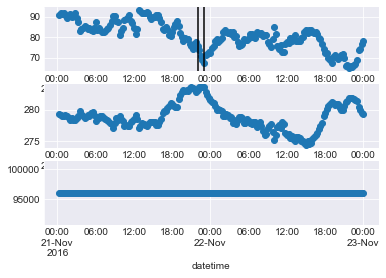

In [118]:
# THESE HAVE NO RH DATA!
# PS02.loc[PS02['height']==3,'RH'].plot()
# PS06.loc[PS06['height']==3,'RH'].plot()
# PS11.loc[PS11['height']==3,'RH'].plot()

fig,ax = plt.subplots(nrows=3)
PS01.loc[PS01['height']==3,'RH'].plot(ax=ax[0],ls='none',marker='o')
PS01.loc[PS01['height']==3,'air_temperature'].plot(ax=ax[1],ls='none',marker='o')
PS01.loc[PS01['height']==3,'air_pressure'].plot(ax=ax[2],ls='none',marker='o')

ax[0].axvline(focusstart,color='k')
ax[0].axvline(focusend,color='k')

In [119]:
PS01['height'].unique()

array([  3.,  10.])

In [120]:
RH = PS01.loc[(PS01['height'] == 3) & (PS01.index >= focusstart) & (PS01.index <= focusend), 'RH']

In [121]:
RH

datetime
2016-11-21 22:00:00    75.442173
2016-11-21 22:15:00    73.610367
2016-11-21 22:30:00    70.686133
2016-11-21 22:45:00    68.690340
2016-11-21 23:00:00    67.312773
Name: RH, dtype: float64

In [122]:
RH_mean = RH.mean()
print(RH_mean)

71.1483573333


In [123]:
T_mean = PS01.loc[(PS01['height'] == 3) & (PS01.index >= focusstart) & (PS01.index <= focusend), 'air_temperature'].mean()
p_mean = PS01.loc[(PS01['height'] == 3) & (PS01.index >= focusstart) & (PS01.index <= focusend), 'air_pressure'].mean()
print(T_mean,p_mean)

(283.51317599999999, 96148.251746272799)


In [124]:
rho_mean = PS01.loc[(PS01['height'] == 3) & (PS01.index >= focusstart) & (PS01.index <= focusend), 'air_density'].mean()
print(rho_mean,p_mean/287./T_mean)

(1.1773344775073595, 1.1816428952366786)


In [125]:
np.exp(5417.*(1./273. - 1./T_mean))

2.0871407657536718

https://earthscience.stackexchange.com/questions/2360/how-do-i-convert-specific-humidity-to-relative-humidity

In [126]:
# calculate the saturation pressure using the Clausius-Clapeyron equation (see Wallace & Hobbs eqn 3.97)
e_s = 611. * np.exp(5417.*(1./273. - 1./T_mean)) # saturation pressure at 273 K is 6.11 hPa = 611 Pa
print(e_s, 'Pa')

(1275.2430078754935, 'Pa')


In [127]:
# calculate the saturation mixing ratio (see Wallace & Hobbs 3.63)
ws = 0.622 * e_s / (p_mean - e_s)
print(ws, 0.622*e_s/p_mean)

(0.008360661914767864, 0.0082497719562467809)


In [128]:
# RH == 100% * w / ws
w = RH_mean/100 * ws

In [129]:
# assume specific humidity ~= mass mixing ratio
Cp = 1005 * (1+0.84*w)
print(Cp)

1010.02170143


## SOWFA setup: driving velocity profile--NOT USED

In [130]:
U0Mag = 9.191
U0Dir = 267.9 * np.pi/180.

In [131]:
-U0Mag * np.sin(U0Dir), -U0Mag * np.cos(U0Dir)

(9.1848272672196298, 0.33679232672196391)

In [132]:
-11 * np.sin(U0Dir), -11 * np.cos(U0Dir)

(10.992612331565219, 0.40308079577212519)

In [133]:
z = np.arange(10,2000,20)
U = 9.191 * (z/80.0)**0.0782

Ugeo = U.copy()
Ugeo[U > 11] = 11.0

# Ugeo2 = 9.191 * (z/80.0)**0.15
# Ugeo2[Ugeo2 > 11] = 11.0

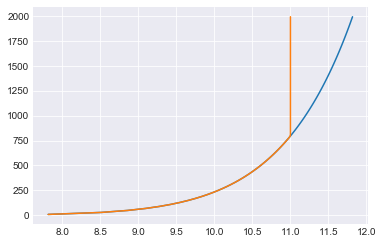

In [134]:
plt.plot(U,z)
plt.plot(Ugeo,z)
# plt.plot(Ugeo2,z)
# plt.ylim((0,500))

In [135]:
wdir = 267.9 * np.pi/180.
Uvec = -Ugeo * np.sin(wdir)
Vvec = -Ugeo * np.cos(wdir)